In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patheffects as pe
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
import os

plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')

In [2]:

data = []
cwd = os.getcwd()
xls = pd.ExcelFile('data/xls/LSD Data SOL.xlsx')
print(xls.sheet_names)
data_xlsx = []
maincurrency = 'SOL'
tokens=['stSOL', 'mSOL', 'scnSOL', 'jSOL']
for sheet in tokens + [maincurrency]:
    _df = xls.parse(sheet)
    _df.dropna(subset=['Date'], inplace=True)
    _df['Date']=pd.to_datetime(_df['Date'])
    _df=_df.set_index('Date')
    if str(sheet) == 'scnSOL':
        _df = _df.loc['04-2022':]
    _df.columns = _df.columns.str.lower()
    _df.token = sheet
    data_xlsx.append(_df)

['Sheet7', 'Sheet6', 'SOL', 'stSOL', 'mSOL', 'scnSOL', 'jSOL']


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: TheSans


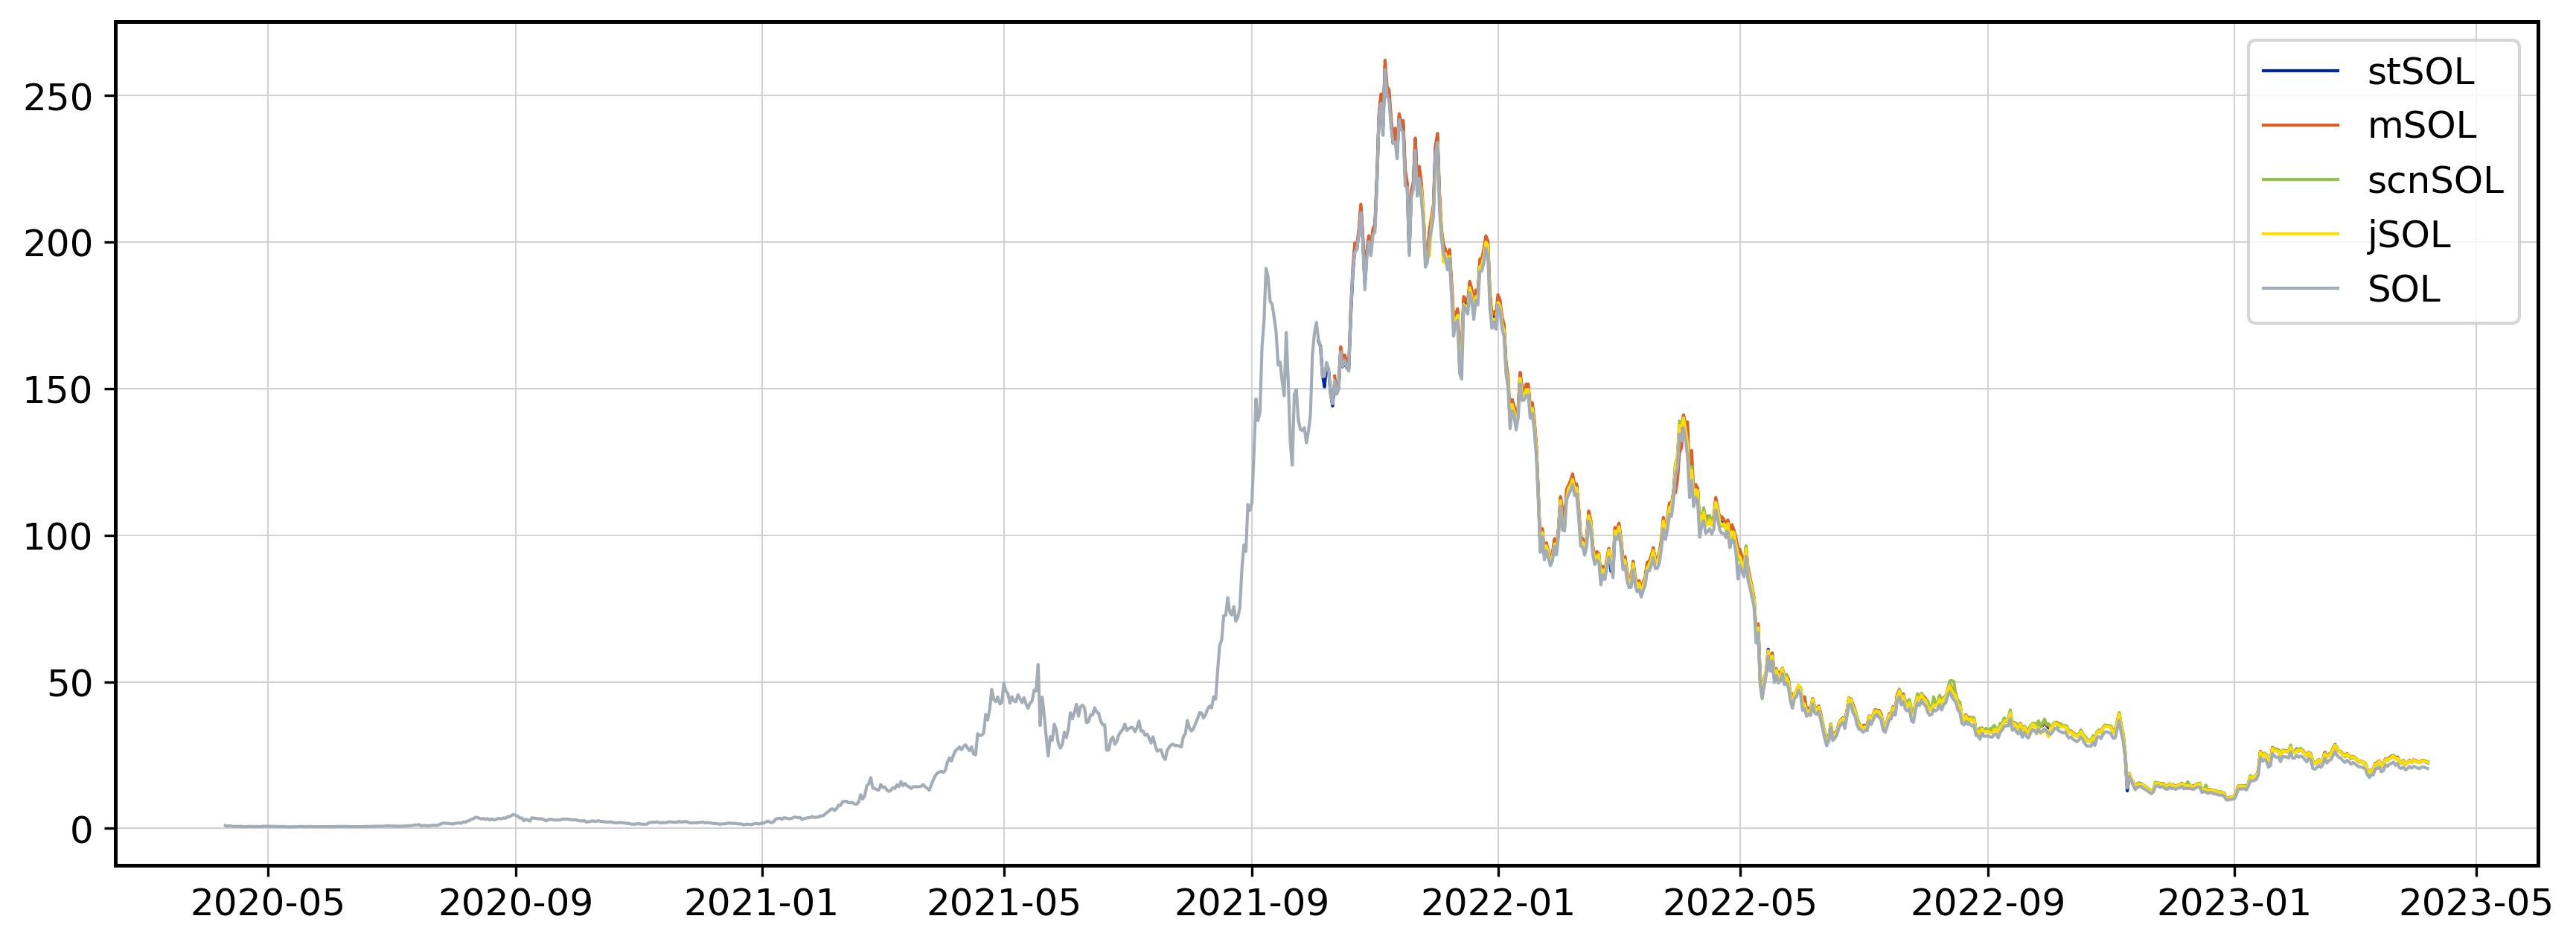

In [3]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(14,5),dpi =300)

for cur in data_xlsx:
    ax.plot(cur.index, cur.close, lw=1, label = cur.token)

ax.set_axisbelow(True)
#ax.set_xlim(reth_fair.index.min(), reth_fair.index.max())
#ax.set_ylim(1,1.1)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')

plt.show()

In [4]:
result = pd.concat([d.close for d in data_xlsx], axis=1, join="outer", keys= [d.token for d in data_xlsx])
#interest = result[[maincurrency]].copy()
#interest['daily']= 0.07 
#interest.drop([maincurrency],inplace=True, axis=1)


result = result.div(result[maincurrency].values,axis=0)
result = result.drop(maincurrency, axis=1)
result.dropna(axis = 0, how = 'all', inplace = True)

interest = result.copy()
interest['daily']= 0.06 

interest = pd.DataFrame(interest['daily'])

sol_data=pd.read_csv('data/sol-usd-max.csv', delimiter = ";")
sol_data['snapped_at']=pd.to_datetime(sol_data['snapped_at'])
sol_data=sol_data.set_index('snapped_at')
sol_data.index.name = 'time'
sol_data = sol_data.tz_localize(None)
interest['daily']=(1+np.array(interest['daily']))**(1/365)
interest['daily_accrued']= interest['daily'].cumprod()
interest = pd.concat([interest, sol_data], axis=1, join="outer")

interest['daily_SOL_change']=interest['price'].pct_change(1)
interest['daily_accrued_SOL']= (1+interest['daily_SOL_change']).cumprod()
interest['monthly_SOL_std'] = interest['daily_SOL_change'].rolling(30).std()
interest['daily_SOL_std_change'] = interest['monthly_SOL_std'].pct_change(1)
interest = interest.dropna()
interest

daily  daily_accrued       price    market_cap  total_volume  \
2021-10-04  1.00016       1.000160  172.855870  5.156712e+10  2.990395e+09   
2021-10-05  1.00016       1.000319  167.877910  5.007272e+10  3.108613e+09   
2021-10-06  1.00016       1.000479  164.369276  4.900864e+10  2.550035e+09   
2021-10-07  1.00016       1.000639  154.094624  4.600294e+10  3.216048e+09   
2021-10-08  1.00016       1.000799  154.259885  4.614561e+10  2.469489e+09   
...             ...            ...         ...           ...           ...   
2023-04-03  1.00016       1.091250   20.565439  7.929638e+09  2.509397e+08   
2023-04-04  1.00016       1.091424   20.436690  7.900169e+09  5.297529e+08   
2023-04-05  1.00016       1.091598   20.921101  8.093519e+09  3.484730e+08   
2023-04-06  1.00016       1.091772   20.982374  8.139781e+09  3.618782e+08   
2023-04-07  1.00016       1.091947   20.609003  7.980951e+09  2.719531e+08   

            daily_SOL_change  daily_accrued_SOL  monthly_SOL_std  \
2021-10-04          0.021553         180.508373         0.079341   
2021-10-05         -0.028798         175.310033         0.078989   
2021-10-06         -0.020900         171.646069         0.079156   
2021-10-07         -0.062510         160.916547         0.074860   
2021-10-08          0.001072         161.089125         0.074196   
...                      ...                ...              ...   
2023-04-03         -0.024572          21.475892         0.047131   
2023-04-04         -0.006260          21.341443         0.046983   
2023-04-05          0.023703          21.847299         0.047178   
2023-04-06          0.002929          21.911285         0.047047   
2023-04-07         -0.017795          21.521384         0.047053   

            daily_SOL_std_change  
2021-10-04             -0.041160  
2021-10-05             -0.004424  
2021-10-06              0.002106  
2021-10-07             -0.054265  
2021-10-08             -0.008880  
...                          ...  
2023-04-03             -0.000480  
2023-04-04             -0.003144  
2023-04-05              0.004145  
2023-04-06             -0.002772  
2023-04-07              0.000129  

[551 rows x 9 columns]

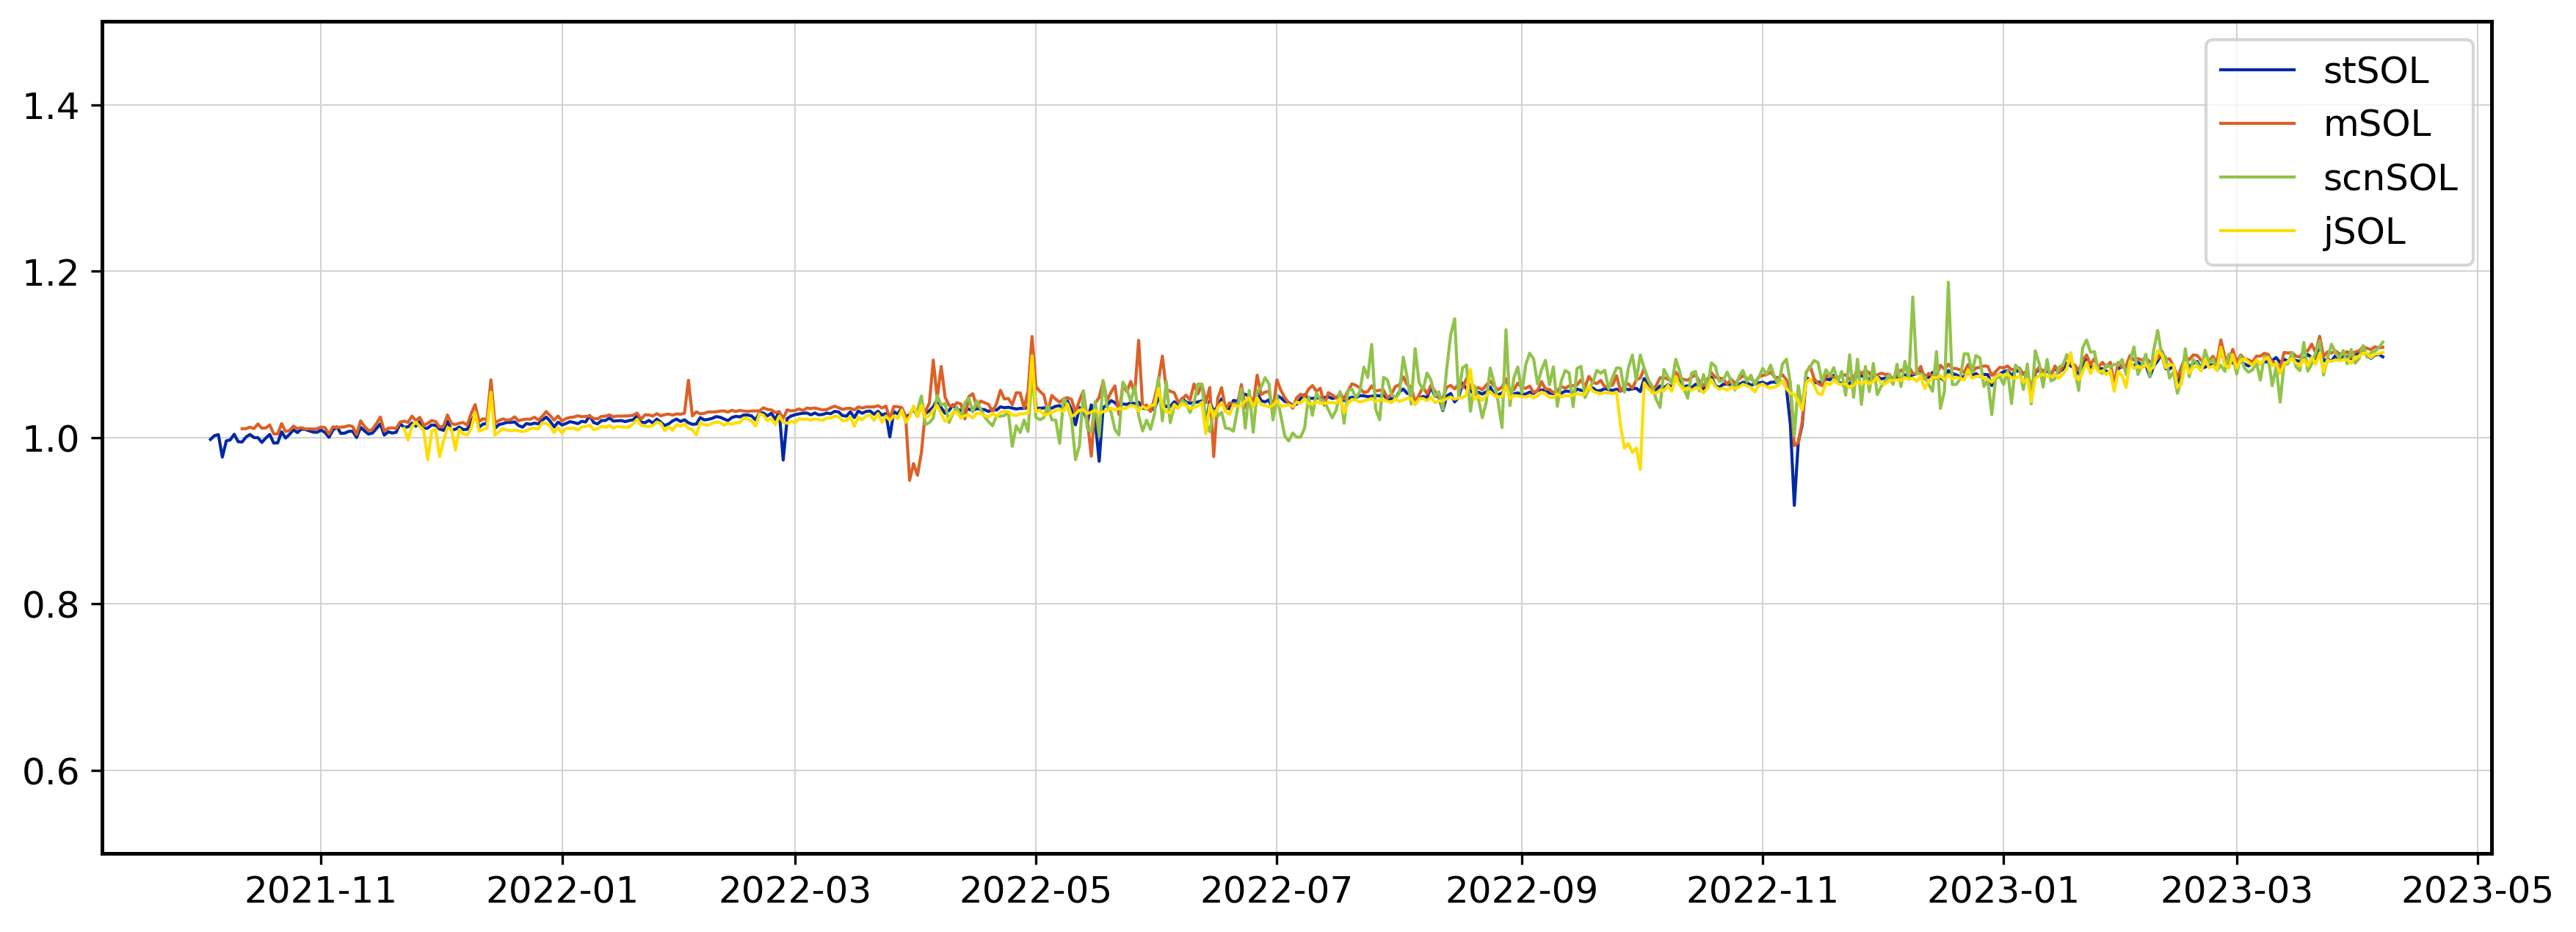

In [5]:

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(14,5),dpi =300)

for col in result.columns:
    ax.plot(result.index, result[col], lw=1, label = col)

ax.set_axisbelow(True)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
ax.set_ylim(0.5,1.5)
fig.set_facecolor('w')

plt.show()

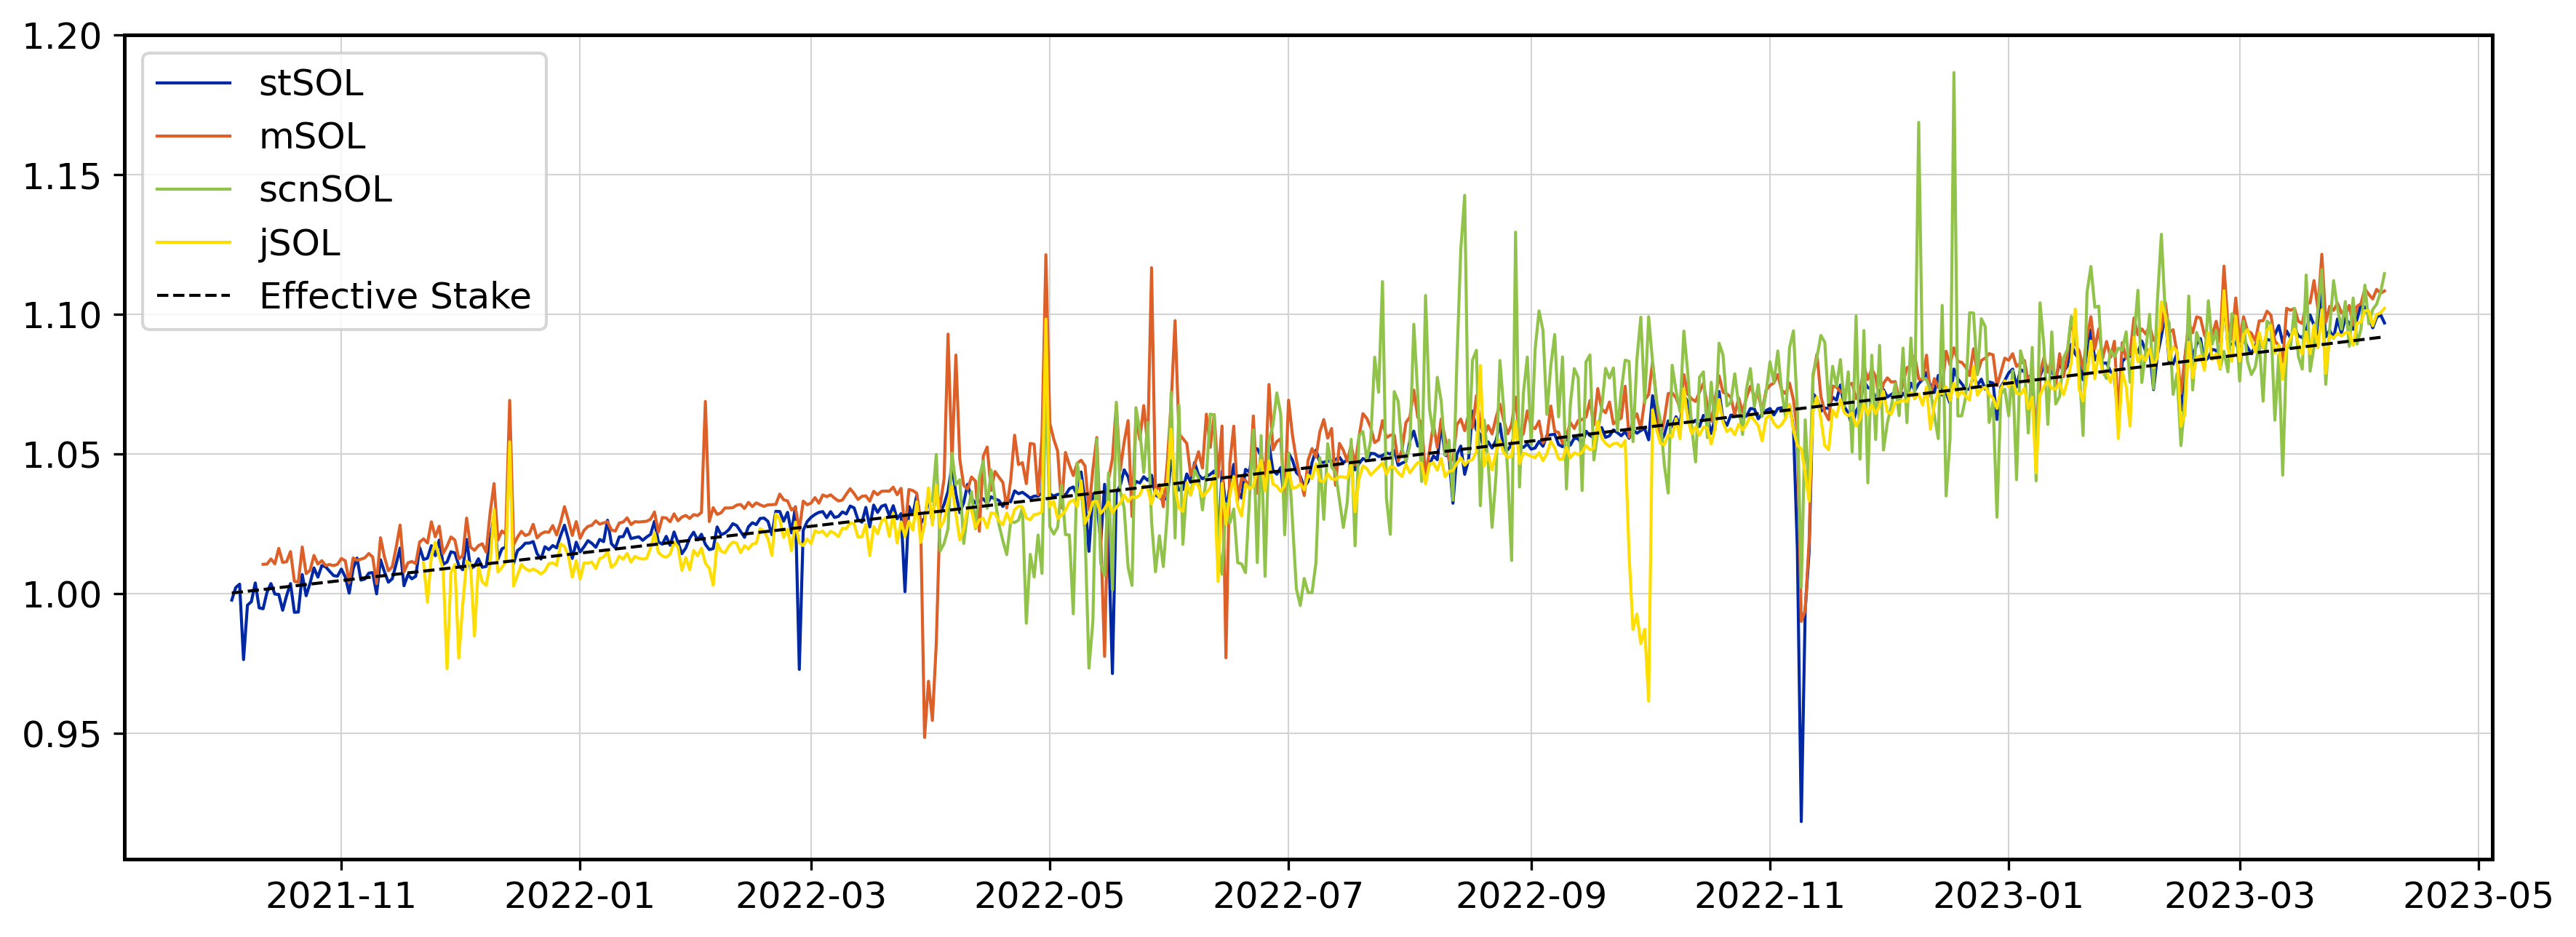

In [6]:

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(14,5),dpi =300)

for col in result.columns:
    ax.plot(result.index, result[col], lw=1, label = col)

ax.plot(result.index, interest['daily_accrued'], color='k', lw=1, ls='--', label='Effective Stake')

ax.set_axisbelow(True)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')

plt.show()

In [7]:
result_with_interest = pd.concat([result, interest.daily], axis=1, join="outer")
#result_with_interest.dropna(subset=['wstETH'], inplace=True)
result_with_interest['daily_accrued']= result_with_interest['daily'].cumprod()

In [8]:
result_with_interest

stSOL      mSOL    scnSOL      jSOL    daily  daily_accrued
2021-10-04  0.997629       NaN       NaN       NaN  1.00016       1.000160
2021-10-05  1.002111       NaN       NaN       NaN  1.00016       1.000319
2021-10-06  1.003338       NaN       NaN       NaN  1.00016       1.000479
2021-10-07  0.976312       NaN       NaN       NaN  1.00016       1.000639
2021-10-08  0.995816       NaN       NaN       NaN  1.00016       1.000799
...              ...       ...       ...       ...      ...            ...
2023-04-03  1.099399  1.107156  1.096615  1.101293  1.00016       1.091250
2023-04-04  1.095161  1.105526  1.101729  1.095931  1.00016       1.091424
2023-04-05  1.098913  1.108952  1.103665  1.099959  1.00016       1.091598
2023-04-06  1.099895  1.107552  1.107820  1.100523  1.00016       1.091772
2023-04-07  1.096921  1.108386  1.114571  1.102173  1.00016       1.091947

[551 rows x 6 columns]

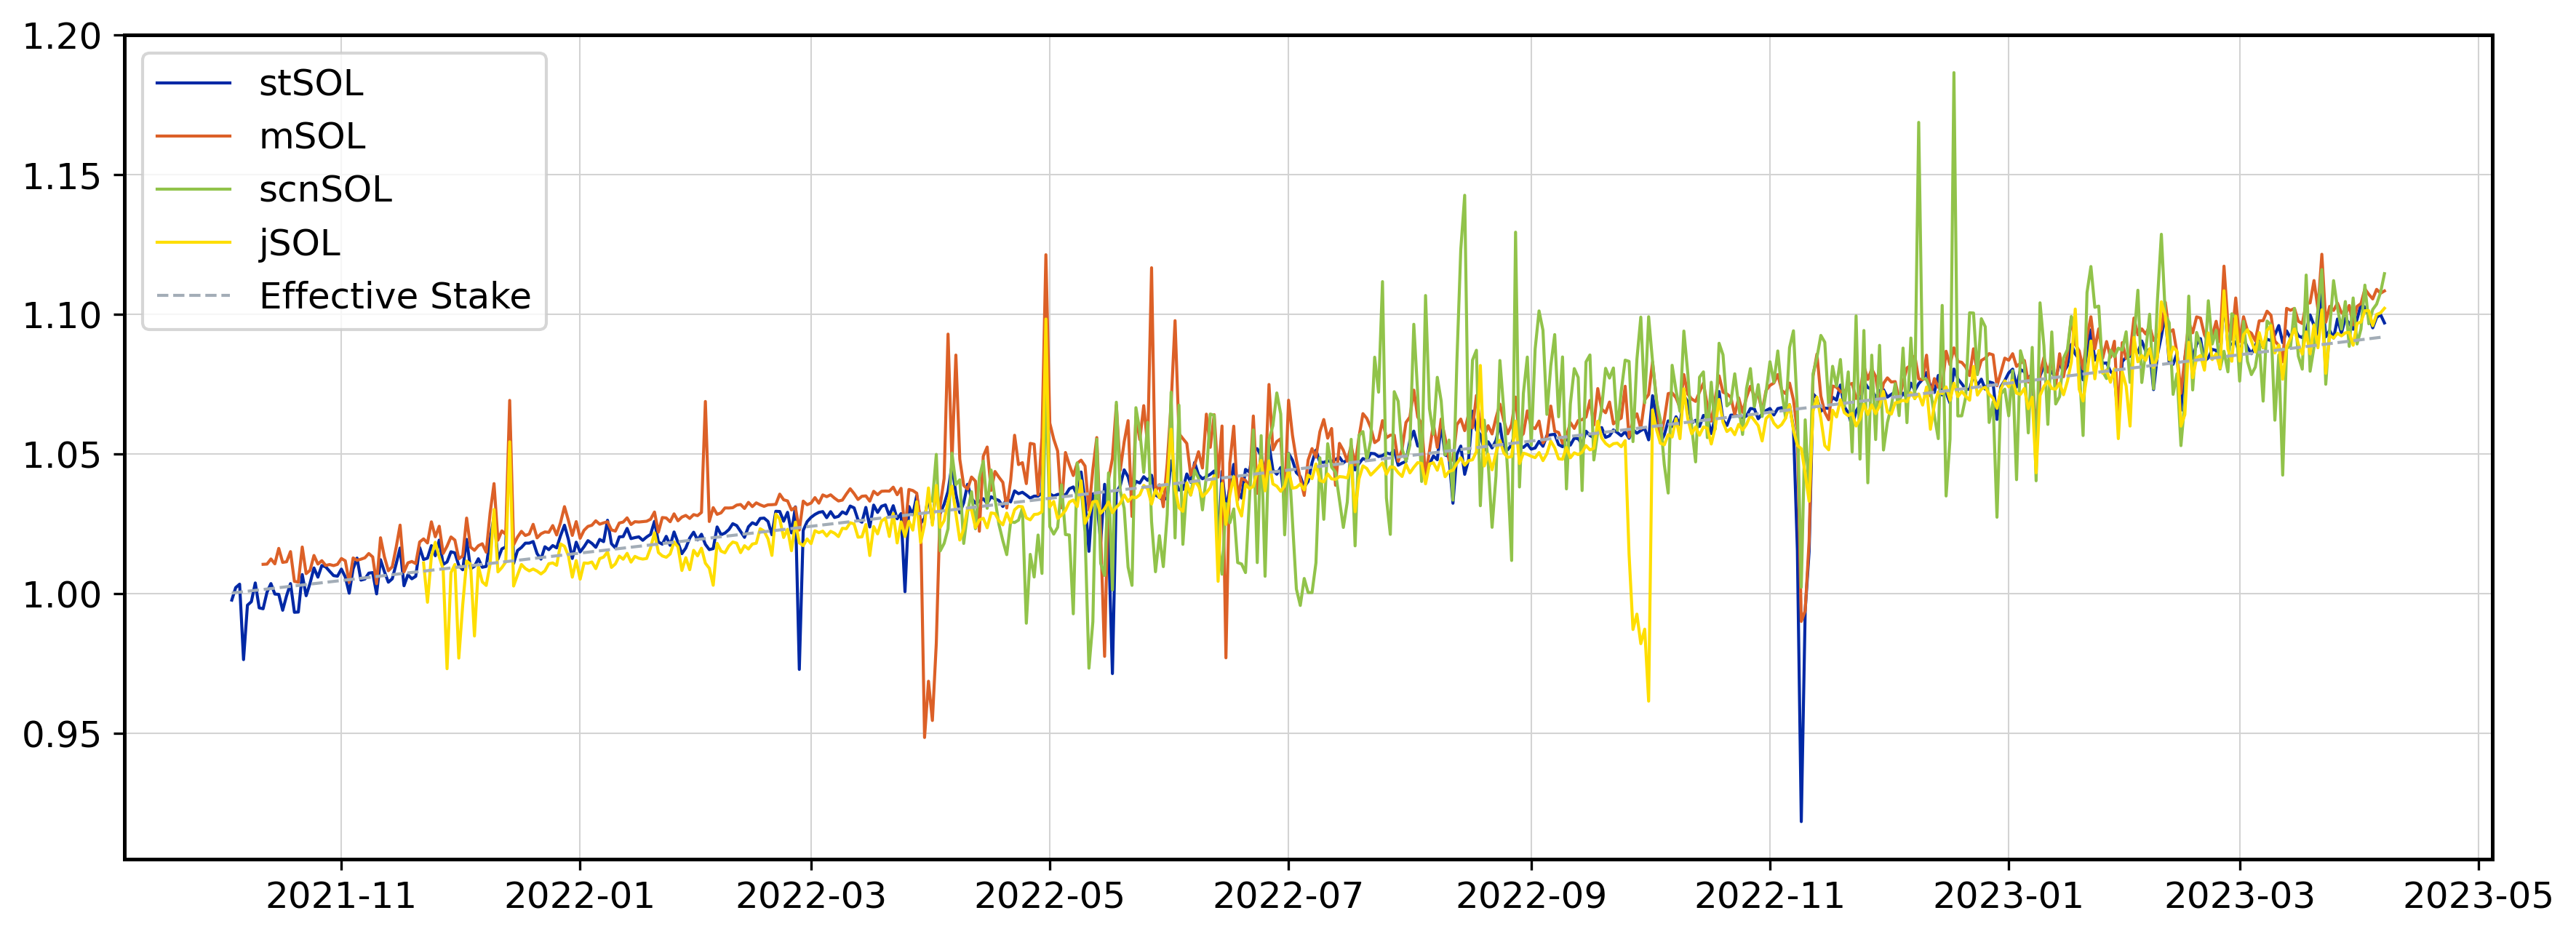

In [9]:
data_to_plot = result_with_interest
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(14,5),dpi =300)

for col in data_to_plot:
    if col in ['daily', 'daily_accrued']:
        continue
    ax.plot(data_to_plot.index, data_to_plot[col].rolling(window=1).mean(), lw=1, label = col)

ax.plot(data_to_plot.index, data_to_plot['daily_accrued'], lw=1, ls='--', label='Effective Stake')

ax.set_axisbelow(True)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')

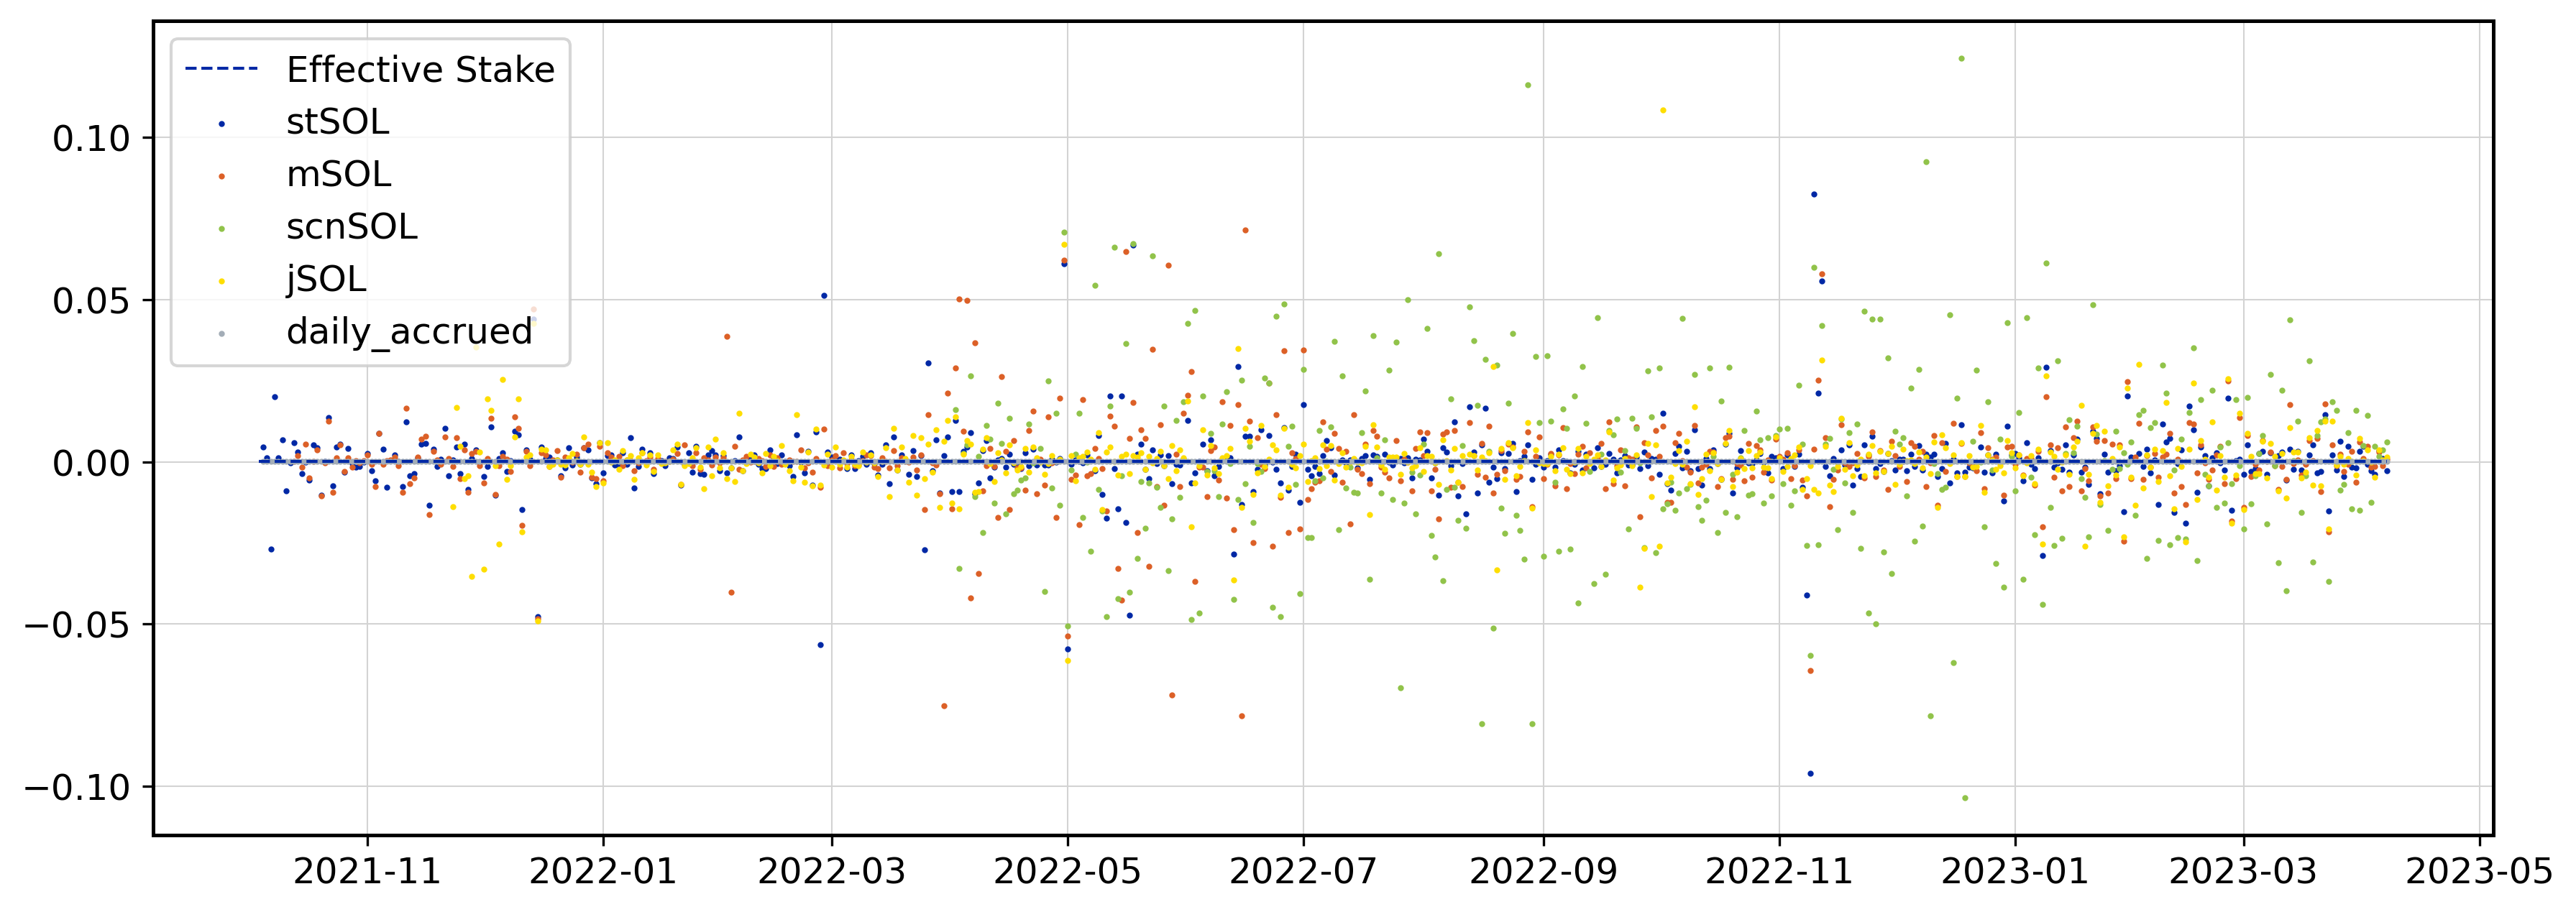

In [10]:
data_to_plot = result_with_interest
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(14,5),dpi =300)

for col in data_to_plot:
    if col == 'daily':
        continue
    ax.scatter(data_to_plot.index, data_to_plot[col].pct_change(1), s=1,lw=1, label = col)

ax.plot(data_to_plot.index, data_to_plot['daily']-1, lw=1, ls='--', label='Effective Stake')

ax.set_axisbelow(True)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')

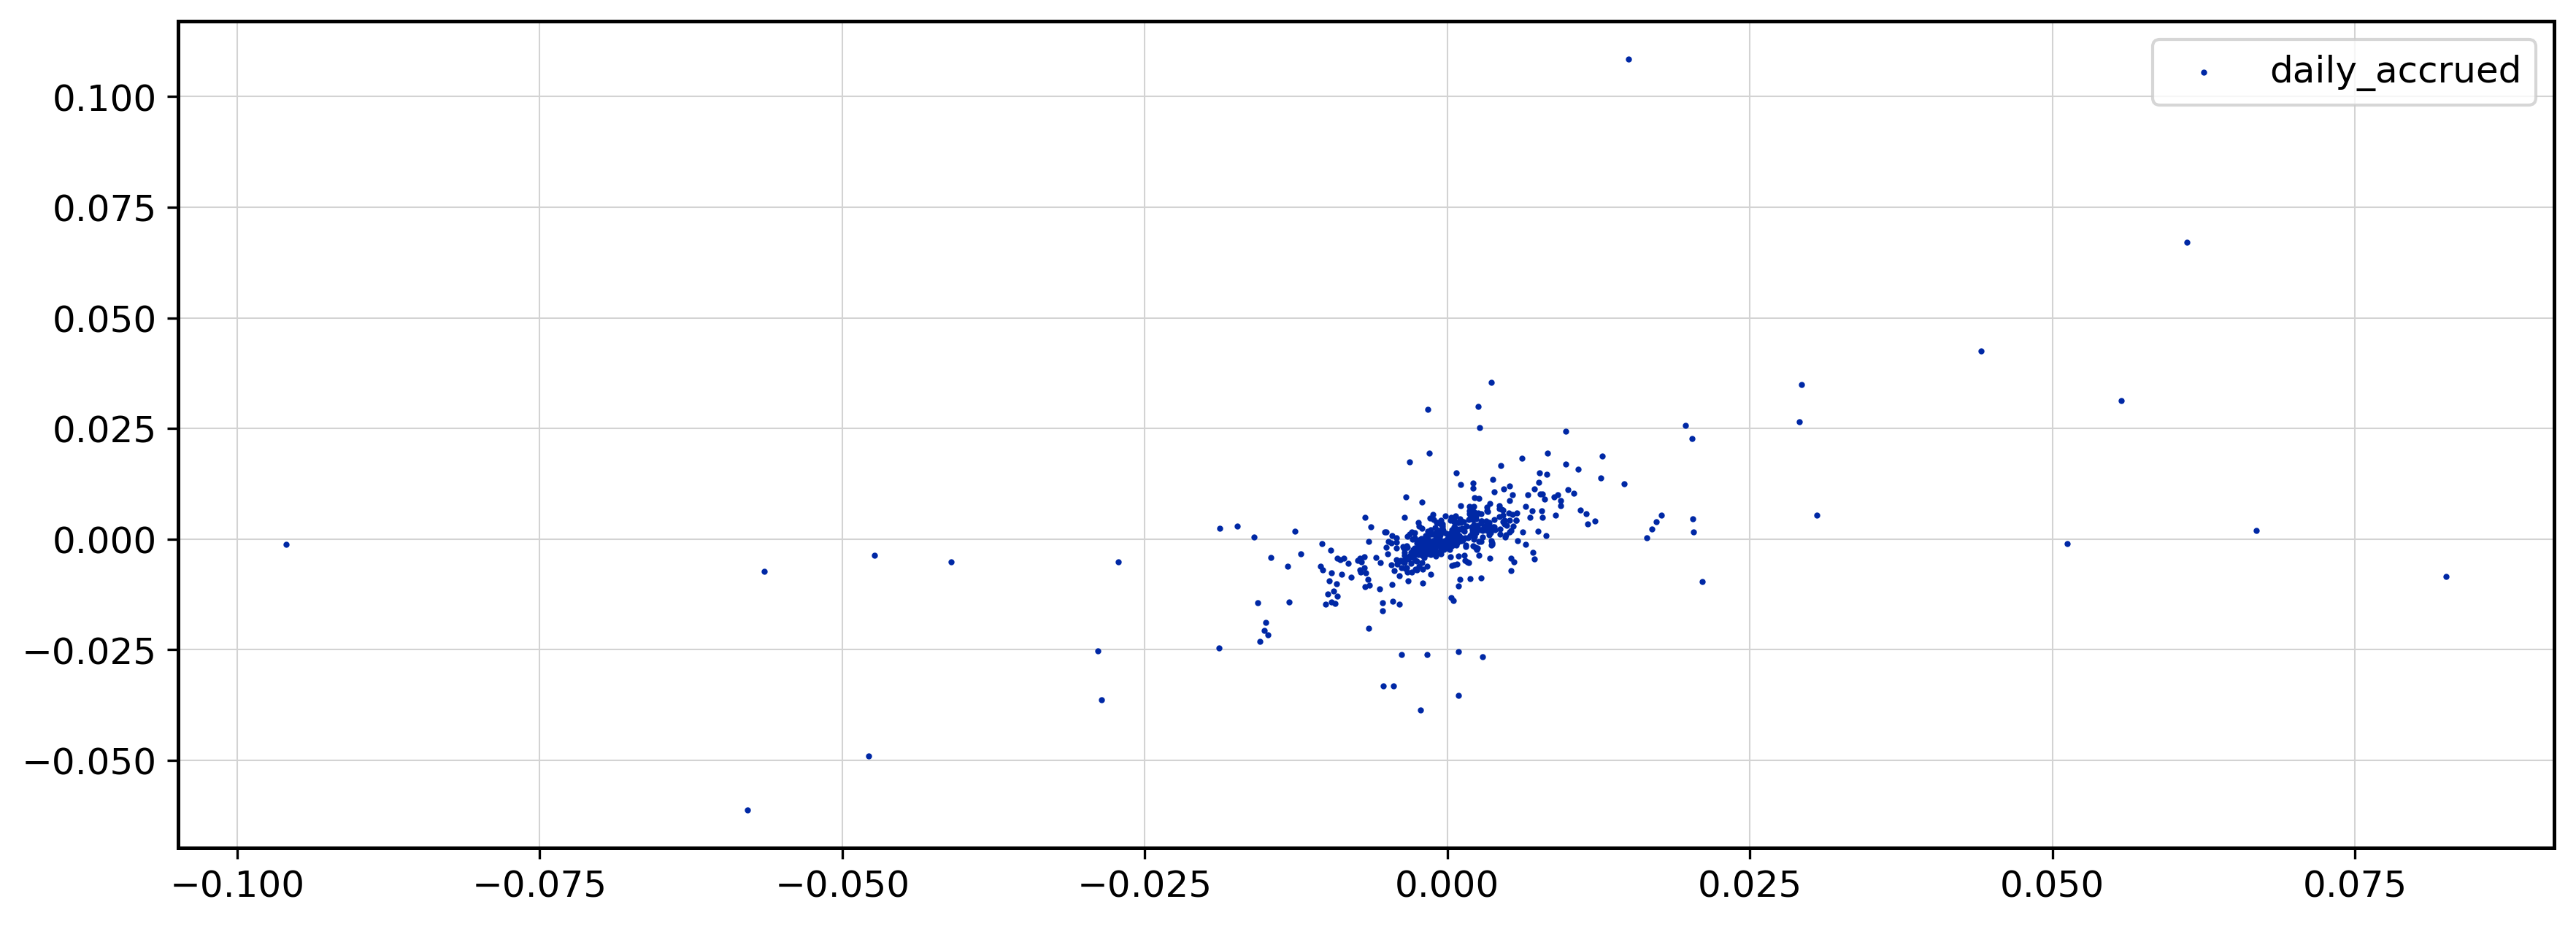

In [11]:
data_to_plot = result_with_interest
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(14,5),dpi =300)

ax.scatter(data_to_plot['stSOL'].pct_change(1), data_to_plot['jSOL'].pct_change(1), s=1,lw=1, label = col)

#ax.plot(data_to_plot.index, data_to_plot['daily']-1, lw=1, ls='--', label='Effective Stake')

ax.set_axisbelow(True)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')

In [12]:
data_to_plot.pct_change(1).describe()

stSOL        mSOL      scnSOL        jSOL  daily  daily_accrued
count  550.000000  542.000000  371.000000  501.000000  550.0      550.00000
mean     0.000234    0.000266    0.000585    0.000232    0.0        0.00016
std      0.011073    0.013819    0.027699    0.011031    0.0        0.00000
min     -0.095927   -0.078335   -0.103643   -0.061285    0.0        0.00016
25%     -0.002606   -0.004464   -0.014966   -0.003343    0.0        0.00016
50%      0.000273    0.000270   -0.000295    0.000267    0.0        0.00016
75%      0.002907    0.004447    0.015056    0.003719    0.0        0.00016
max      0.082551    0.071428    0.124432    0.108513    0.0        0.00016

In [13]:
#df[df['A'].isnull()].index.tolist()

In [14]:
_df = result_with_interest.copy()
adjusted_results = result_with_interest.copy()
for col in tokens:
    adjusted_results[col]= (adjusted_results[col]/_df.loc[(min(_df[_df[col].notnull()].index.tolist()))][col])*_df.loc[(min(_df[_df[col].notnull()].index.tolist()))]['daily_accrued']


    

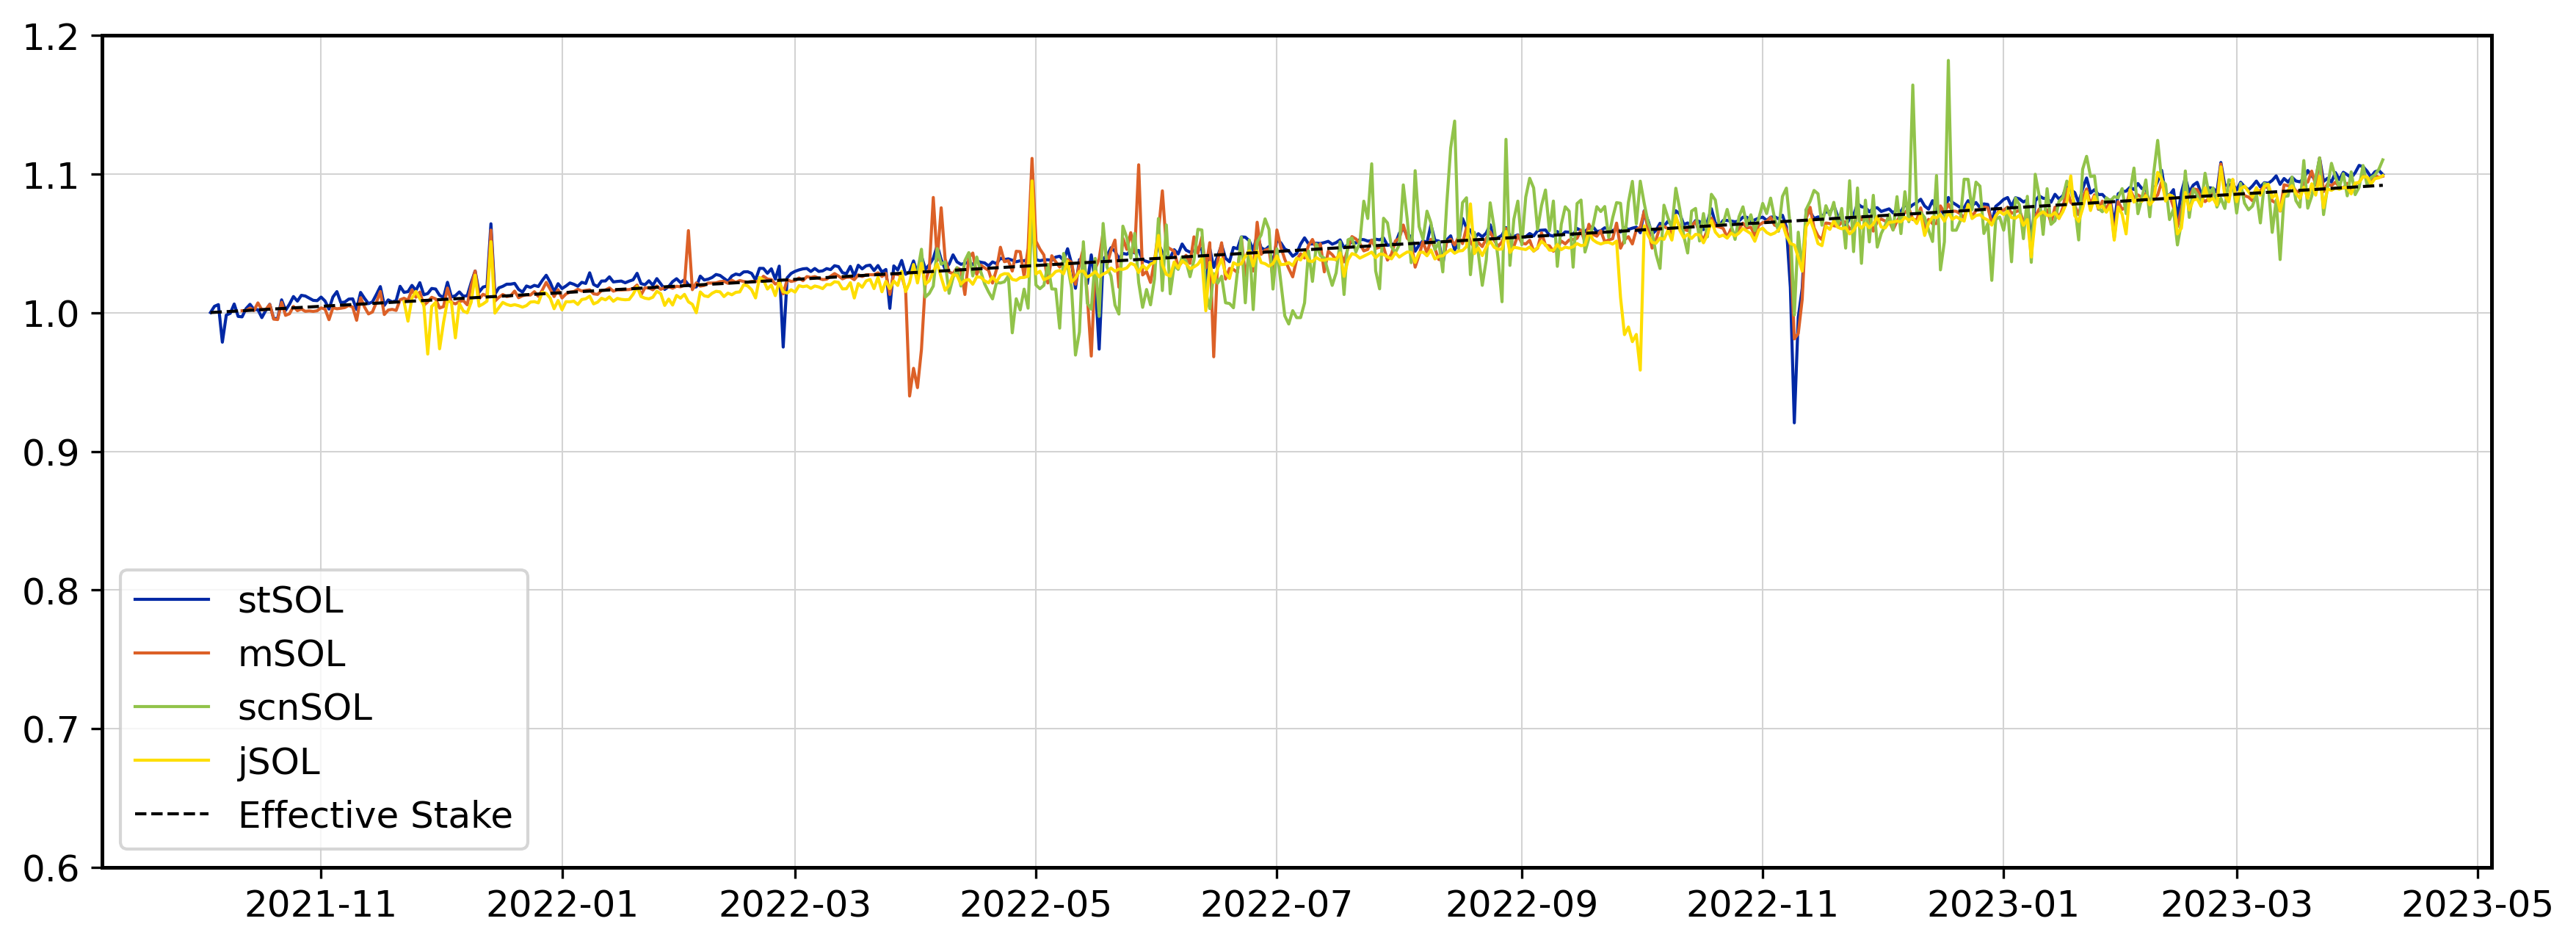

In [15]:
data_to_plot = adjusted_results
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(14,5),dpi =300)

for col in data_to_plot:
    if col in ['daily', 'daily_accrued']:
        continue
    ax.plot(data_to_plot.index, data_to_plot[col], lw=1, label = col)

ax.plot(data_to_plot.index, data_to_plot['daily_accrued'], color = 'k', lw=1, ls='--', label='Effective Stake')


ax.set_ylim(0.6,1.2)
ax.set_xlim()
ax.set_axisbelow(True)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')

In [16]:
df1 =  adjusted_results



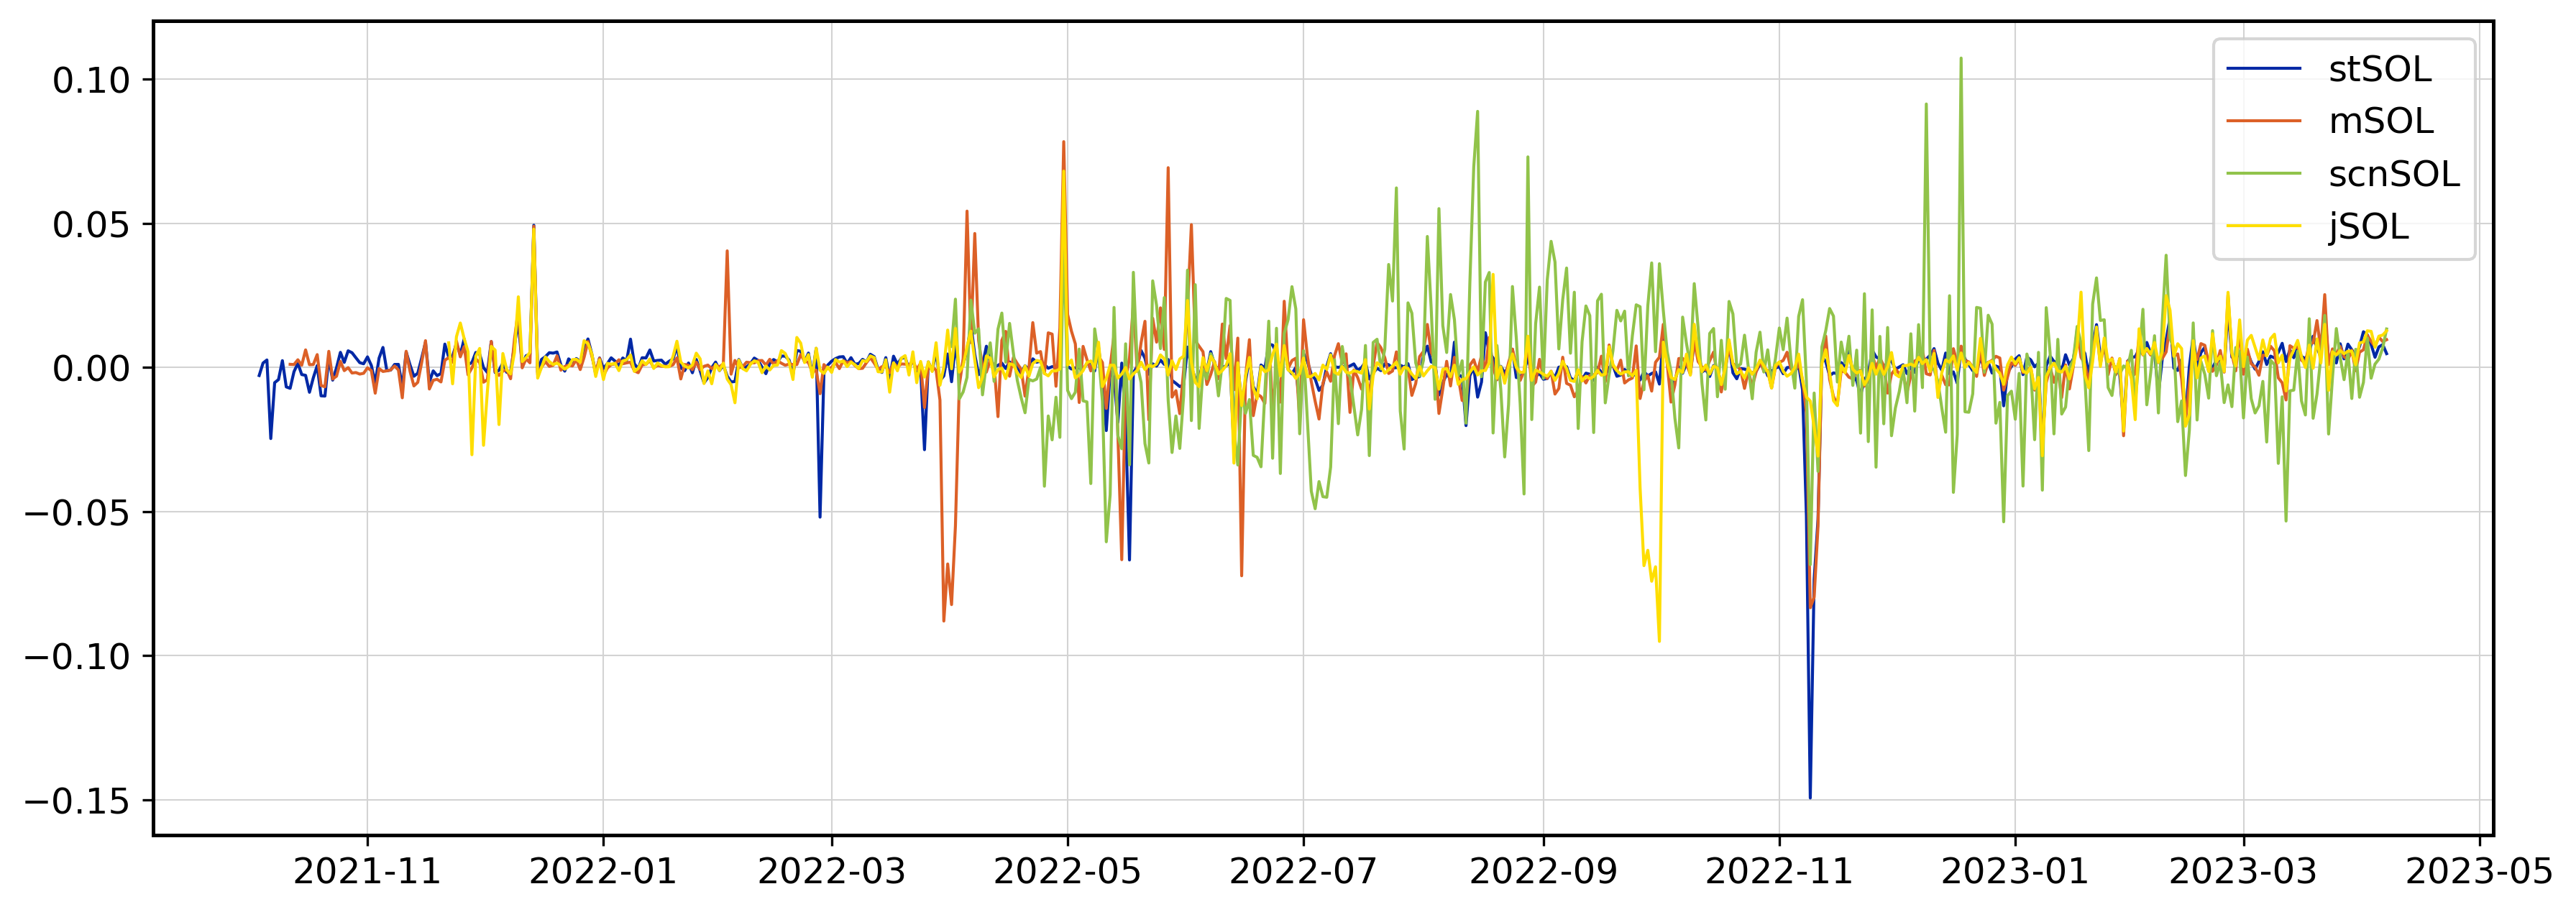

In [17]:
from scipy import signal
#detrended = signal.detrend(df['Number of Passengers'].values)


data_to_plot = adjusted_results
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(14,5),dpi =300)

for col in data_to_plot:
    if col in ['daily', 'daily_accrued']:
        continue
    ax.plot(data_to_plot[data_to_plot[col].notnull()].index, signal.detrend(data_to_plot[data_to_plot[col].notnull()][col].values), lw=1, label = col)

#ax.plot(data_to_plot.index, data_to_plot['daily_accrued'], lw=1, ls='--', label='Effective Stake')

ax.set_axisbelow(True)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')

In [18]:
data_to_plot[data_to_plot[col].notnull()][col].values

array([1.00015965, 1.00031933, 1.00047904, 1.00063877, 1.00079852,
       1.0009583 , 1.00111811, 1.00127794, 1.0014378 , 1.00159768,
       1.00175759, 1.00191753, 1.00207749, 1.00223747, 1.00239748,
       1.00255752, 1.00271758, 1.00287767, 1.00303778, 1.00319792,
       1.00335808, 1.00351827, 1.00367849, 1.00383873, 1.003999  ,
       1.00415929, 1.00431961, 1.00447995, 1.00464032, 1.00480071,
       1.00496113, 1.00512158, 1.00528205, 1.00544255, 1.00560307,
       1.00576362, 1.00592419, 1.00608479, 1.00624541, 1.00640607,
       1.00656674, 1.00672744, 1.00688817, 1.00704892, 1.0072097 ,
       1.00737051, 1.00753134, 1.00769219, 1.00785308, 1.00801398,
       1.00817492, 1.00833588, 1.00849686, 1.00865787, 1.00881891,
       1.00897997, 1.00914105, 1.00930217, 1.00946331, 1.00962447,
       1.00978566, 1.00994688, 1.01010812, 1.01026939, 1.01043068,
       1.010592  , 1.01075334, 1.01091471, 1.01107611, 1.01123753,
       1.01139898, 1.01156045, 1.01172195, 1.01188348, 1.01204

In [19]:
_df = adjusted_results.copy()
excess_returns = adjusted_results.copy()
excess_returns['daily']=_df['daily']-1
for col in tokens:
    excess_returns[col] = _df[col].pct_change(1)

for col in tokens:
    excess_returns[col] =  excess_returns[excess_returns[col].notna()][col]-excess_returns['daily']



    

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: TheSans


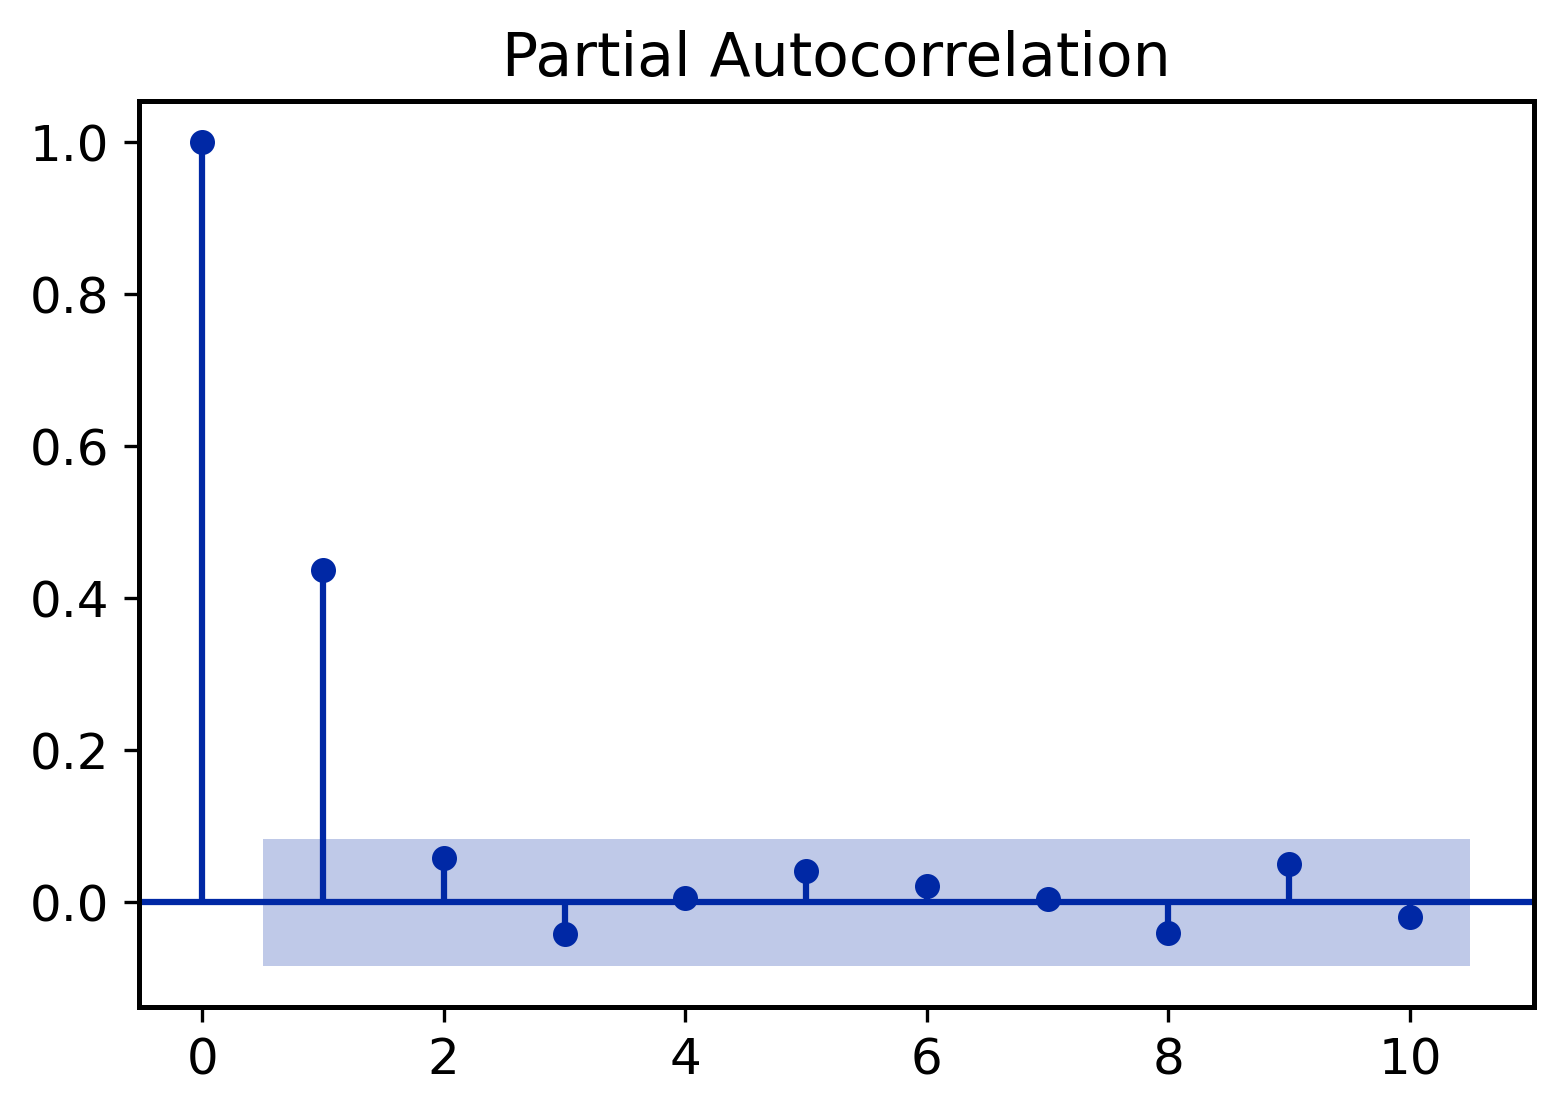

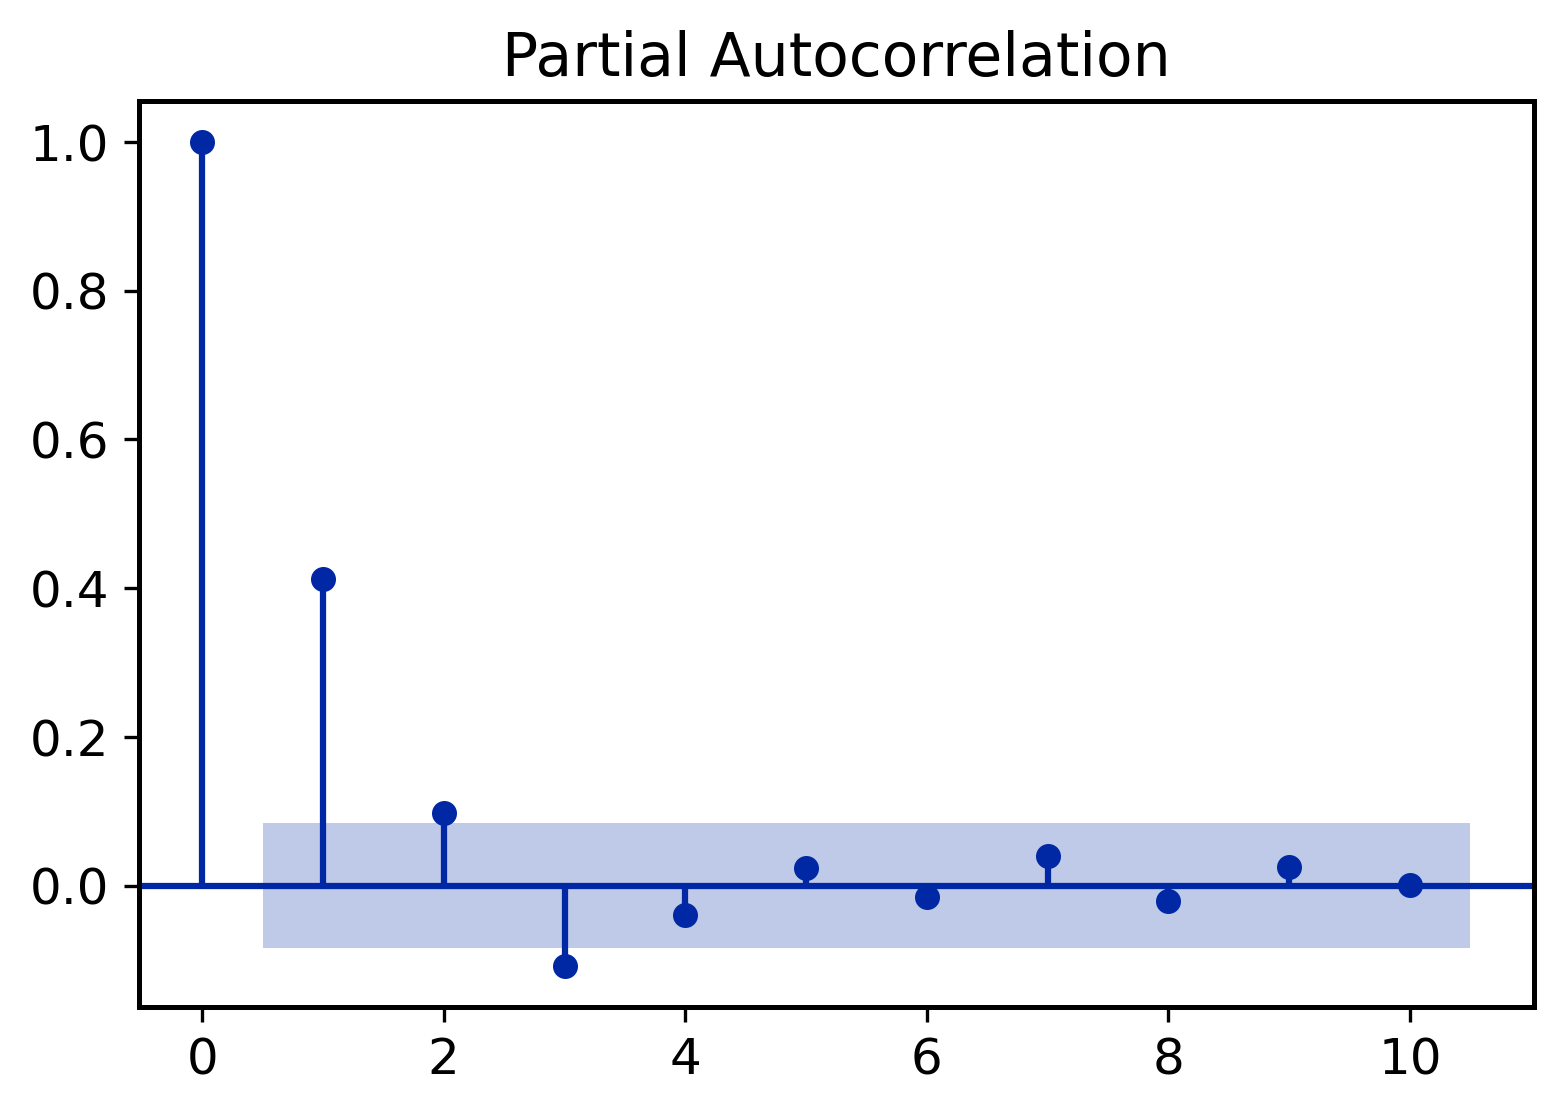

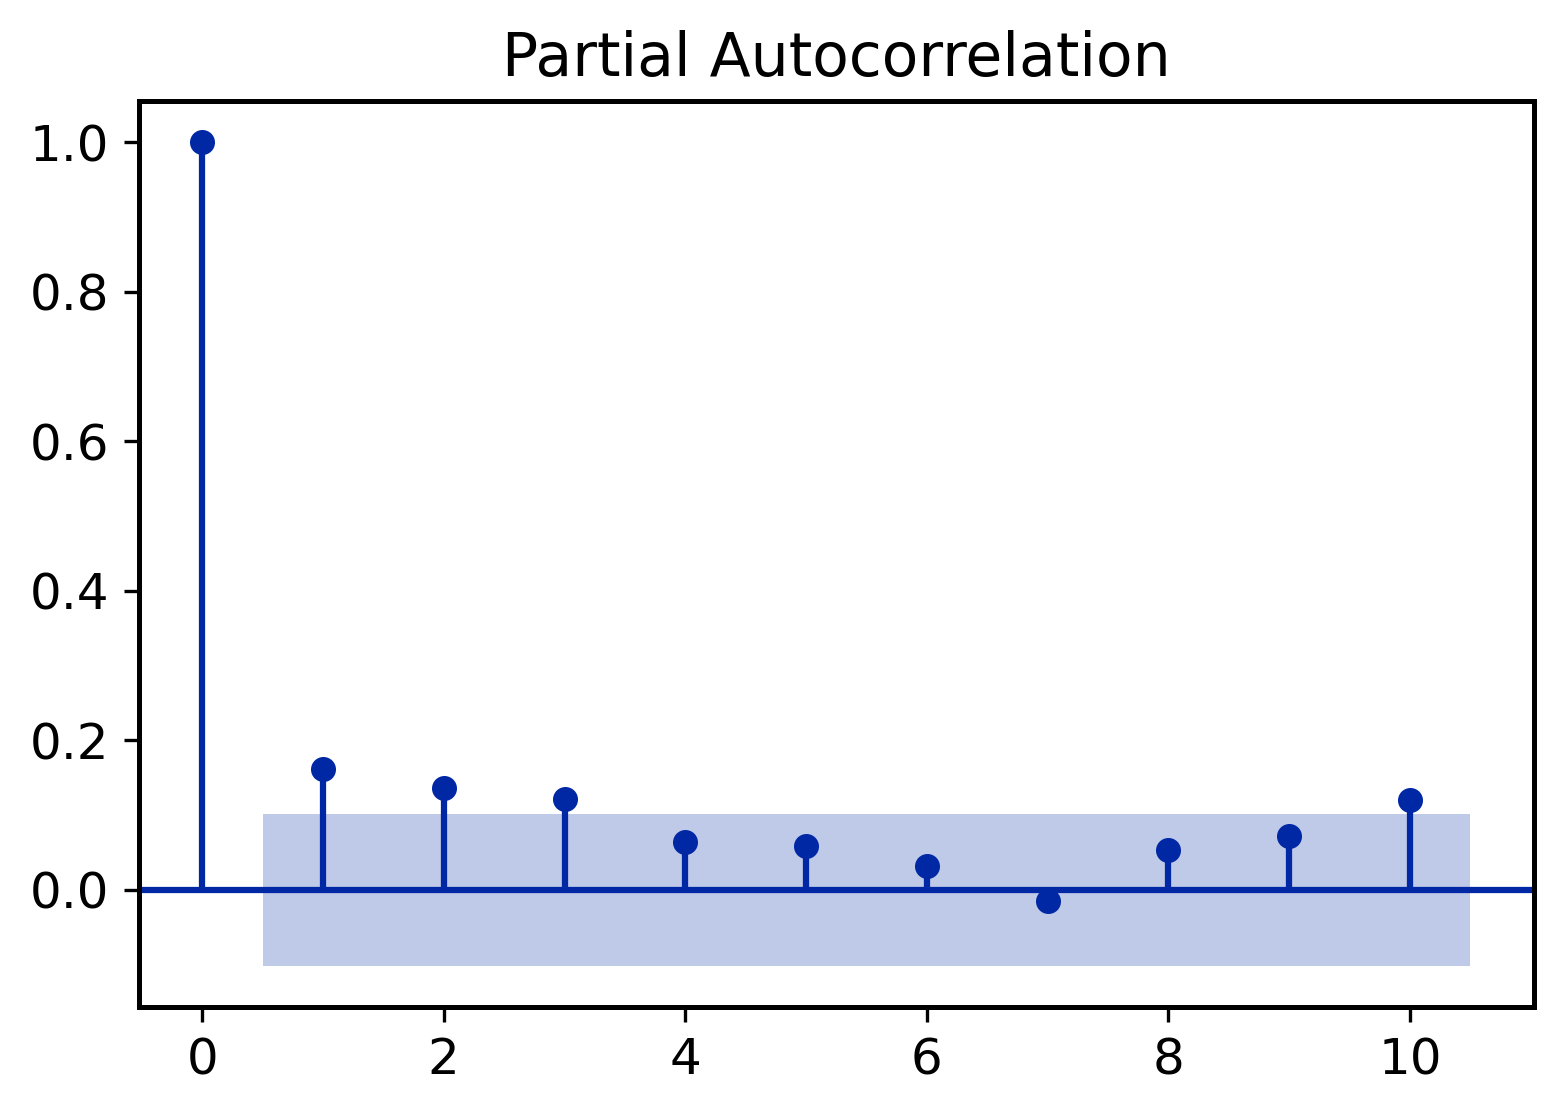

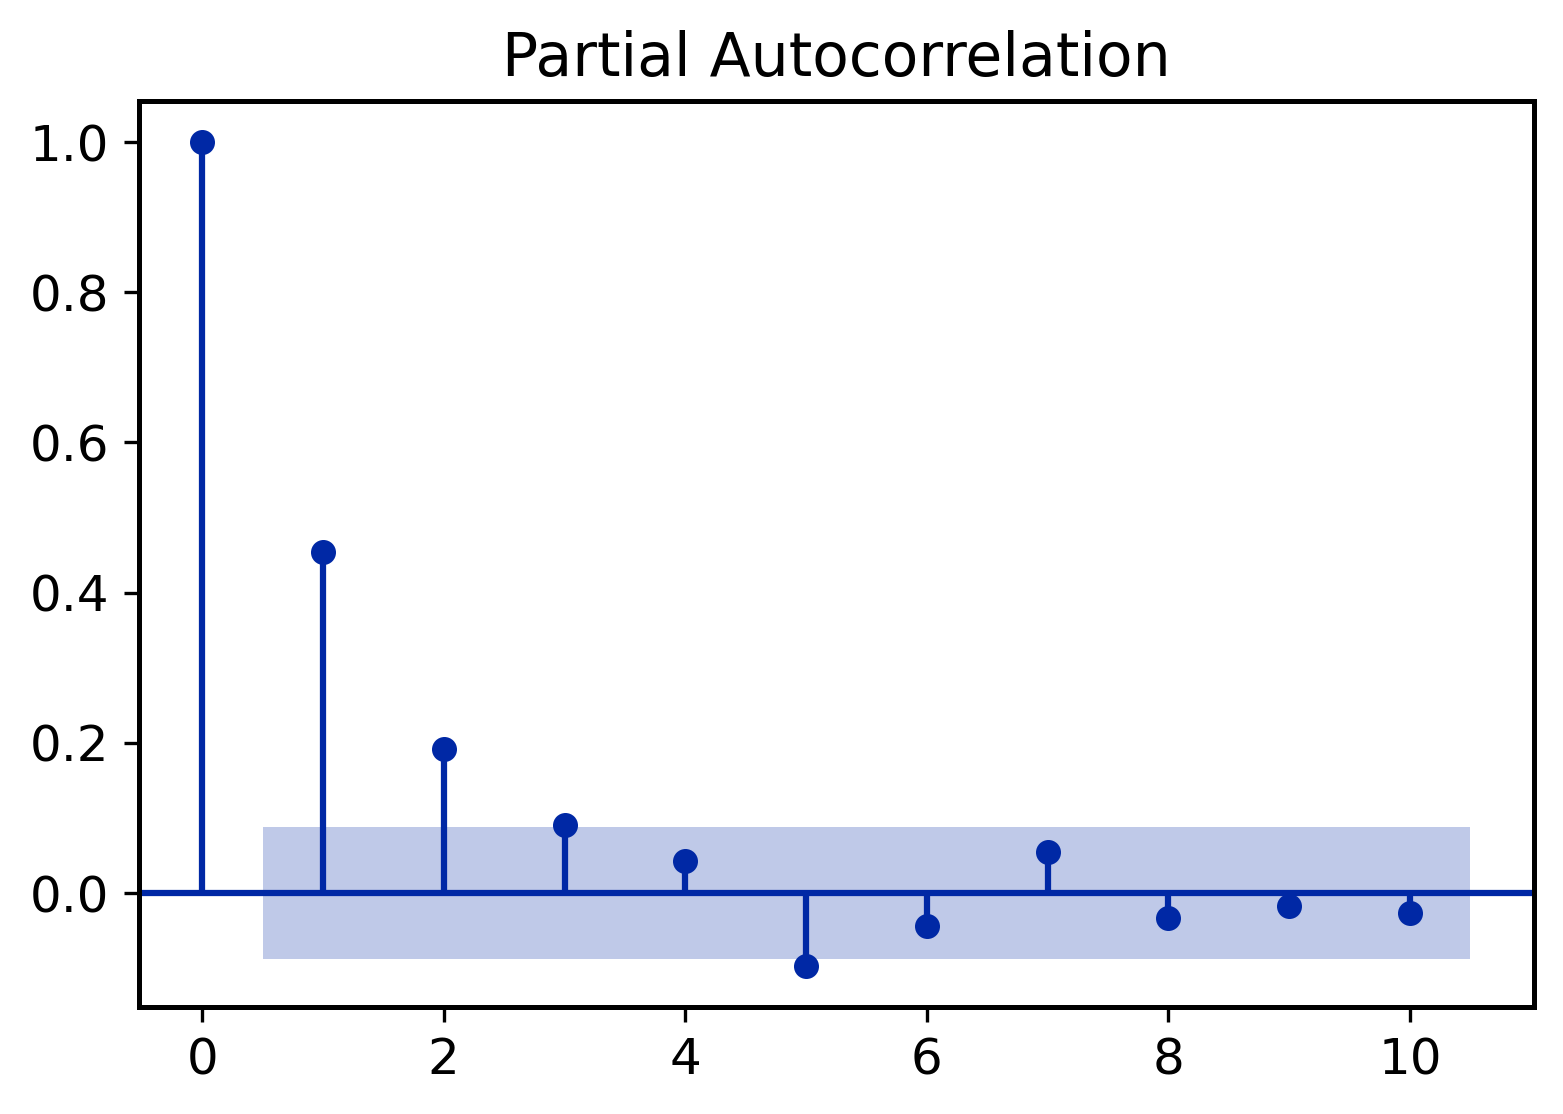

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
_df = adjusted_results.copy()
ret_diff = adjusted_results.copy()
ret_diff['daily']=_df['daily']-1

for col in tokens:
    ret_diff[col] =  ret_diff[ret_diff[col].notna()][col]-ret_diff['daily_accrued']
    plot_pacf(ret_diff[col].dropna(), lags=10)
    plt.show()


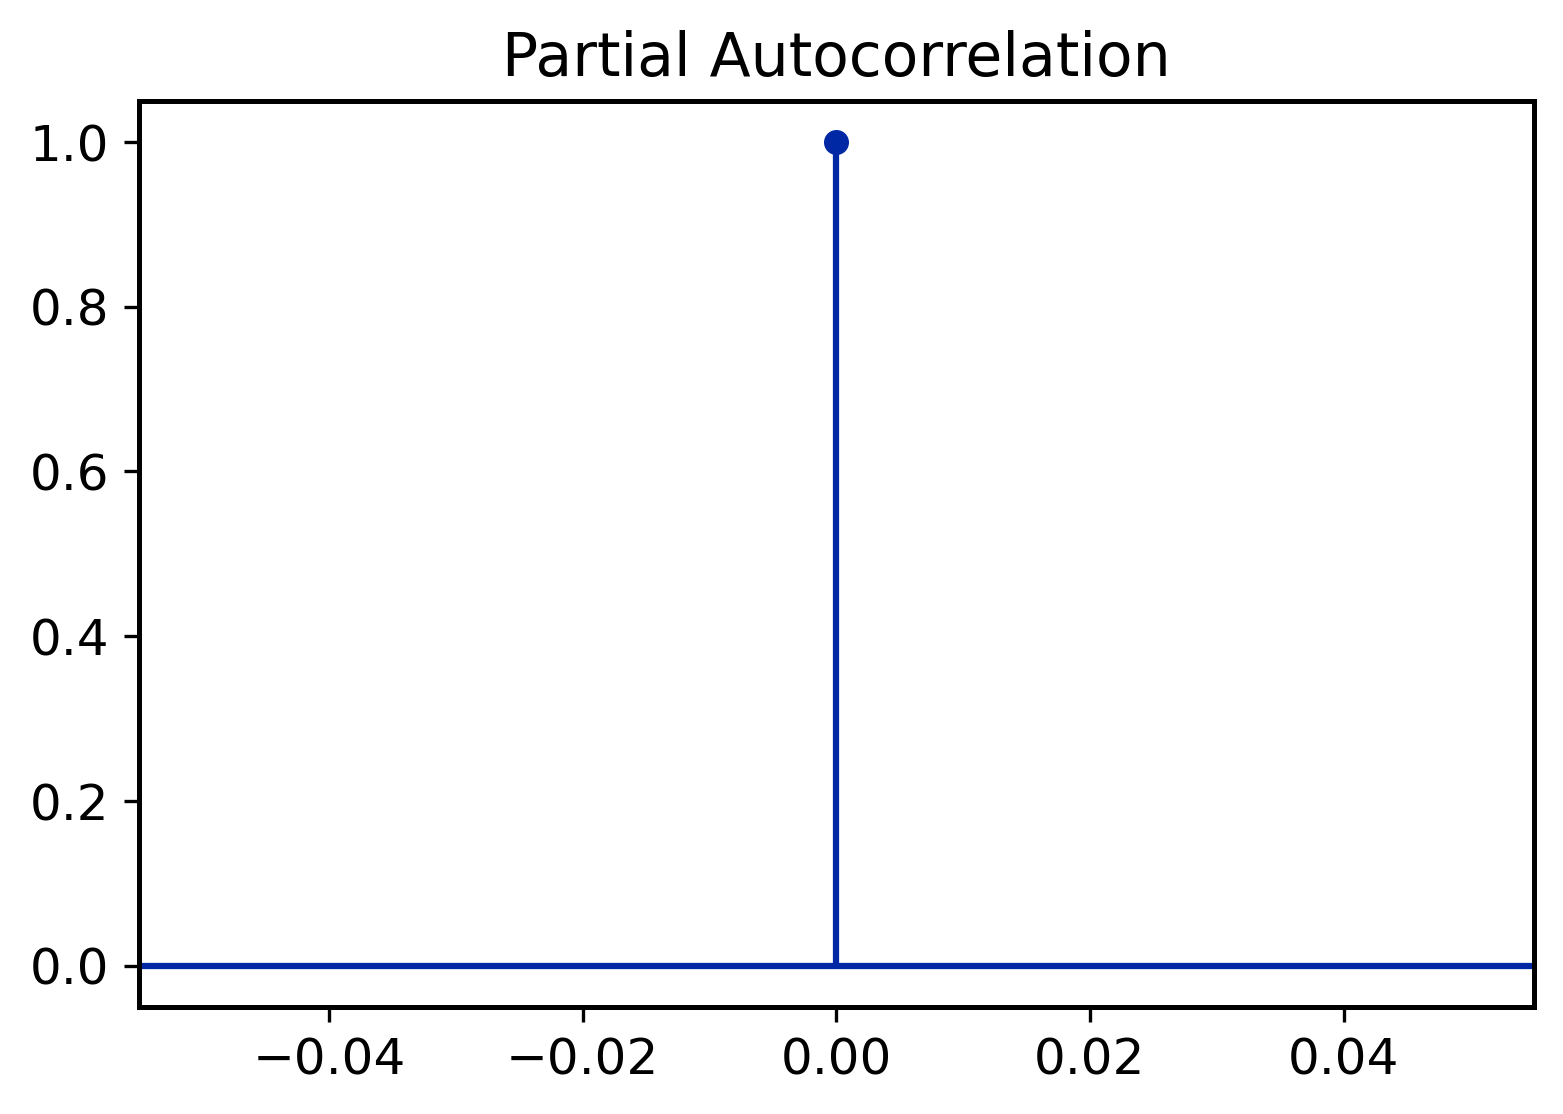

In [21]:
plot_pacf(ret_diff['jSOL'], lags=10)
plt.show()


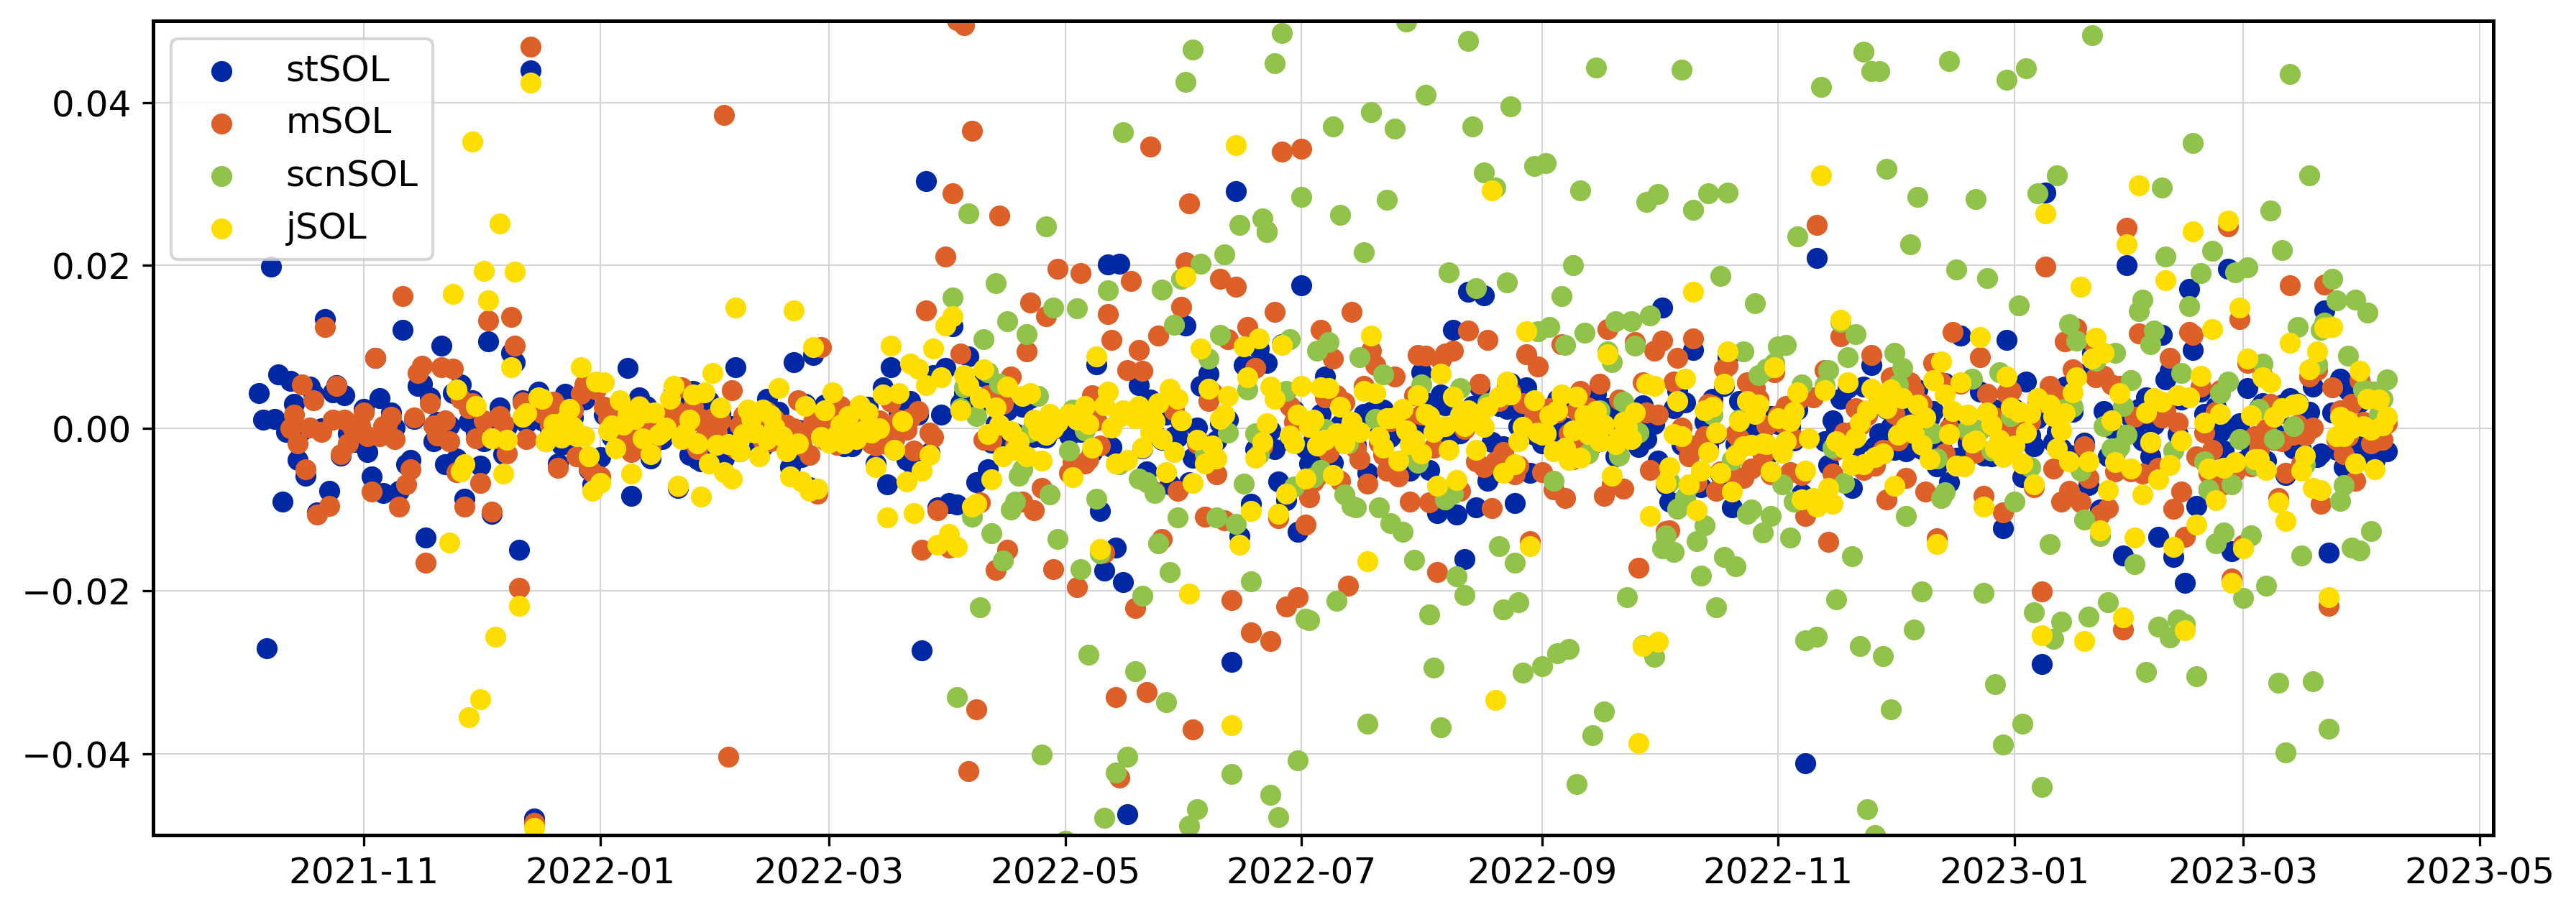

In [22]:
from scipy import signal
#detrended = signal.detrend(df['Number of Passengers'].values)


data_to_plot = excess_returns
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(14,5),dpi =300)

for col in data_to_plot:
    if col in ['daily', 'daily_accrued']:
        continue
    ax.scatter(data_to_plot[col].index, data_to_plot[col], lw=1, label = col)

#ax.plot(data_to_plot.index, data_to_plot['daily_accrued'], lw=1, ls='--', label='Effective Stake')

ax.set_axisbelow(True)
ax.set_ylim(-0.05,0.05)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')

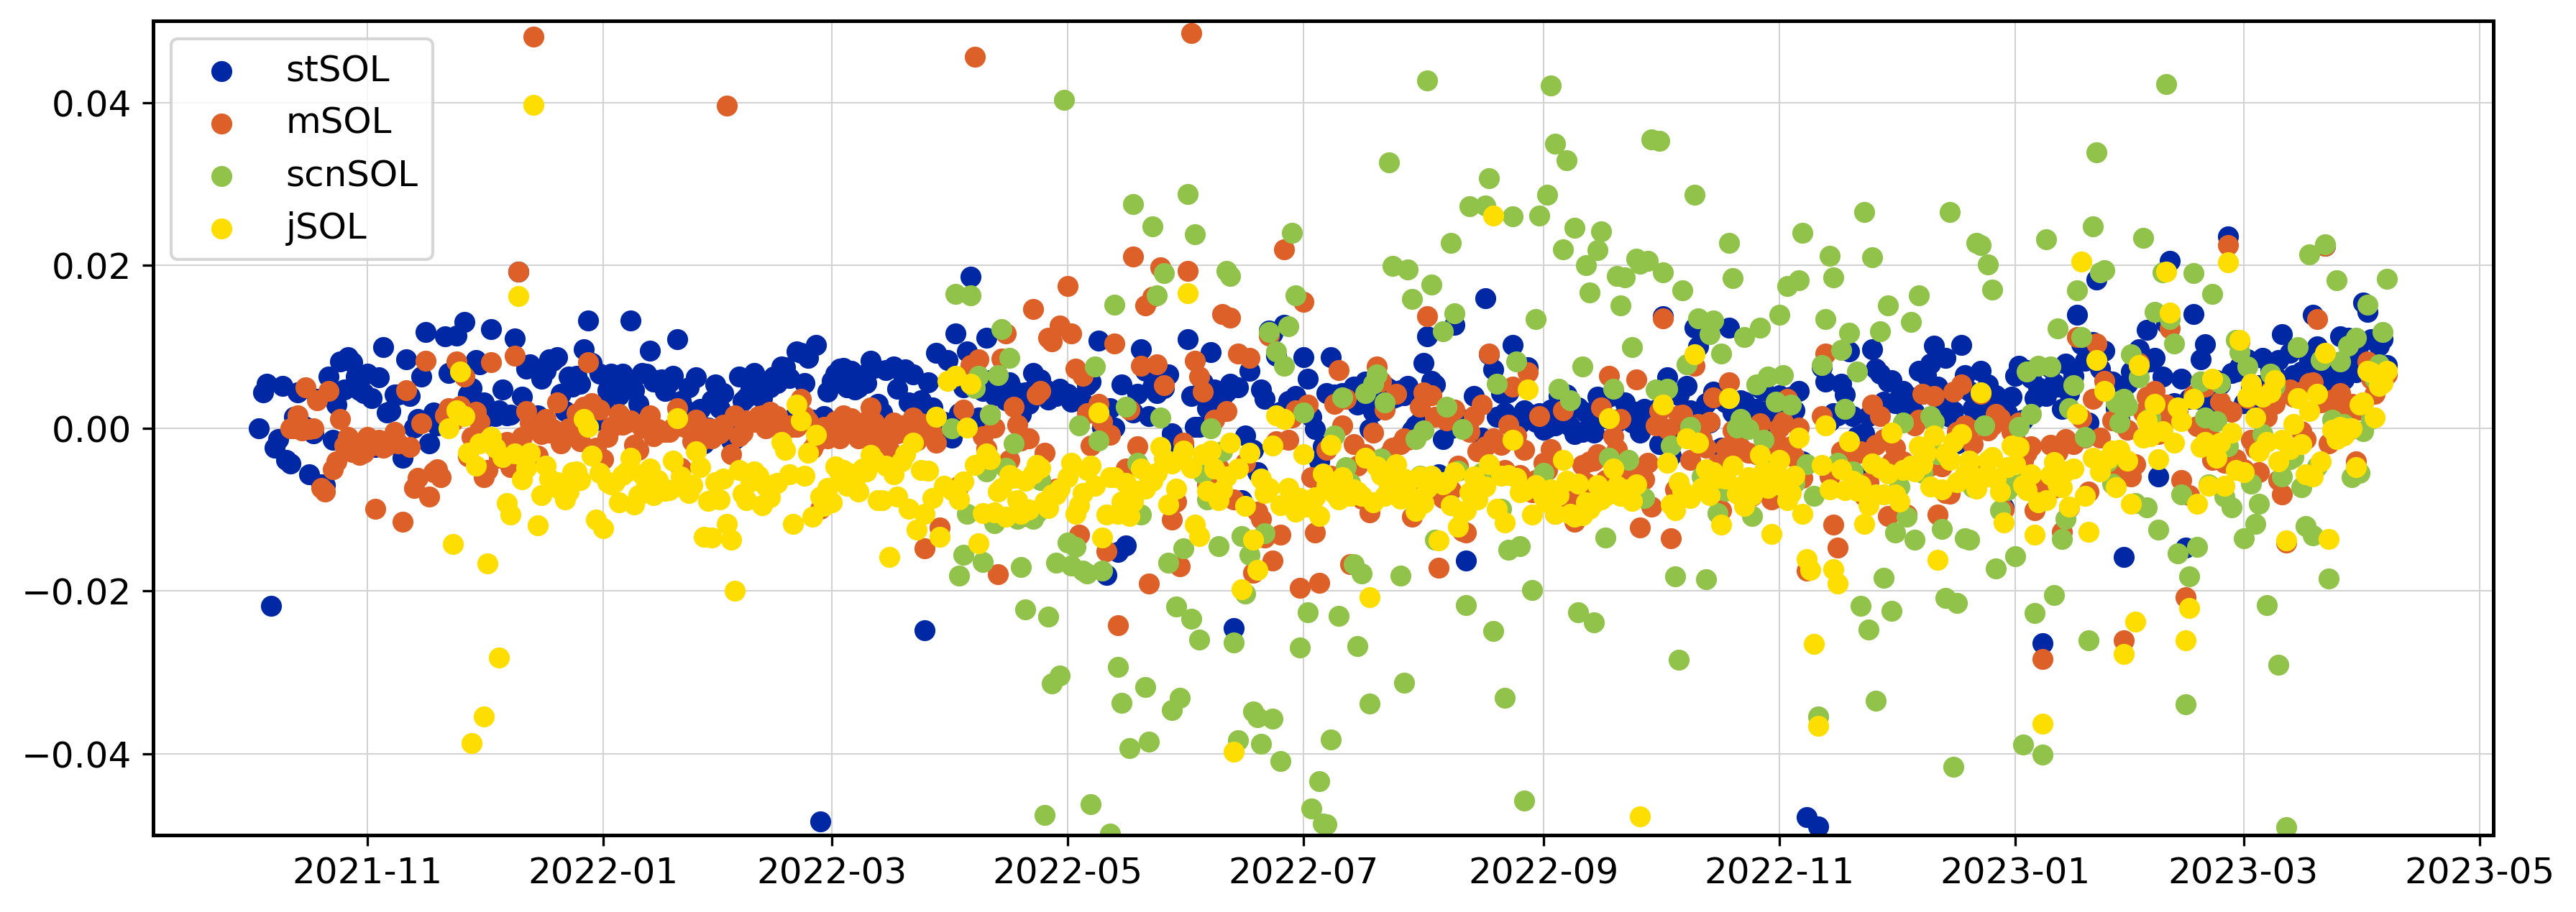

In [23]:
from scipy import signal
#detrended = signal.detrend(df['Number of Passengers'].values)


data_to_plot = ret_diff
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(14,5),dpi =300)

for col in data_to_plot:
    if col in ['daily', 'daily_accrued']:
        continue
    ax.scatter(data_to_plot[col].index, data_to_plot[col], lw=1, label = col)

#ax.plot(data_to_plot.index, data_to_plot['daily_accrued'], lw=1, ls='--', label='Effective Stake')

ax.set_axisbelow(True)
ax.set_ylim(-0.05,0.05)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')

In [24]:
excess_returns.describe()

stSOL        mSOL      scnSOL        jSOL      daily  \
count  550.000000  542.000000  371.000000  501.000000  551.00000   
mean     0.000074    0.000107    0.000426    0.000073    0.00016   
std      0.011073    0.013819    0.027699    0.011031    0.00000   
min     -0.096087   -0.078495   -0.103803   -0.061445    0.00016   
25%     -0.002765   -0.004624   -0.015125   -0.003502    0.00016   
50%      0.000113    0.000110   -0.000455    0.000107    0.00016   
75%      0.002747    0.004287    0.014896    0.003559    0.00016   
max      0.082392    0.071269    0.124272    0.108353    0.00016   

       daily_accrued  
count     551.000000  
mean        1.045383  
std         0.026567  
min         1.000160  
25%         1.022357  
50%         1.045046  
75%         1.068239  
max         1.091947

C:\Users\malte\AppData\Local\Temp/ipykernel_15836/2208906254.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
No handles with labels found to put in legend.


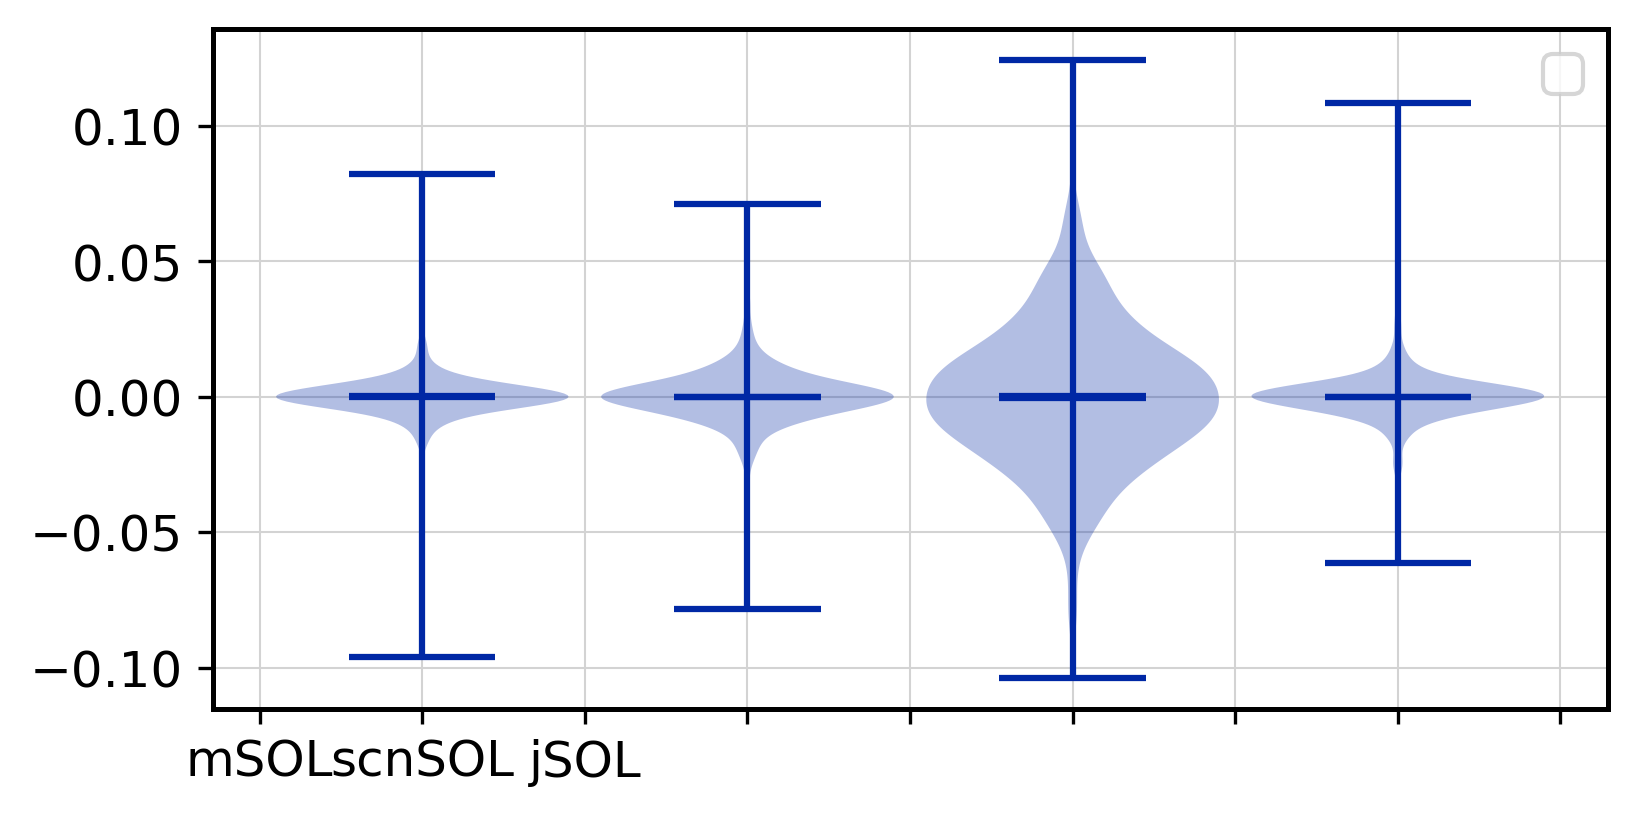

In [25]:
from scipy import signal
#detrended = signal.detrend(df['Number of Passengers'].values)


data_to_plot = excess_returns
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(6,3),dpi =300)

violin = []
labels = []
for col in data_to_plot:
    if col in ['daily', 'daily_accrued']:
        continue
    violin.append(data_to_plot[data_to_plot[col].notna()][col].values)
    labels.append(col)

vplot = ax.violinplot(violin, positions=None, widths=0.9, showmeans=True, showextrema=True, showmedians=True, points=300, bw_method=None)
ax.set_xticklabels(labels)
#ax.plot(data_to_plot.index, data_to_plot['daily_accrued'], lw=1, ls='--', label='Effective Stake')

ax.set_axisbelow(True)
#ax.set_ylim(-0.05,0.05)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')

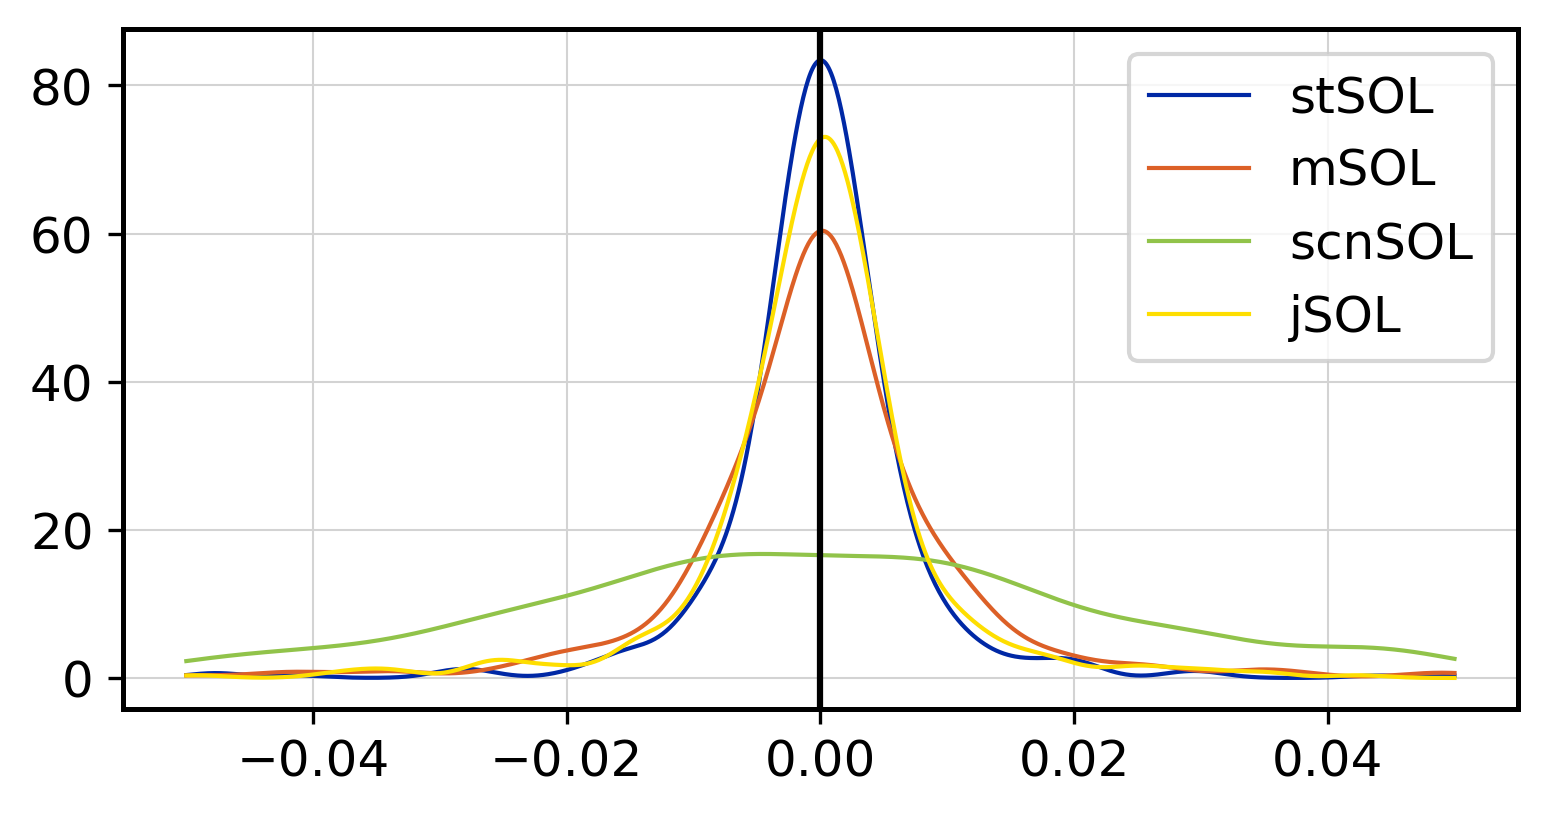

In [26]:
from scipy.stats import gaussian_kde


data_to_plot = excess_returns
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(6,3),dpi =300)

for col in data_to_plot:
    if col in ['daily', 'daily_accrued']:
        continue
    d = data_to_plot[data_to_plot[col].notnull()][col].values
    density = gaussian_kde(d)

    density.covariance_factor = lambda : 0.2
    density._compute_covariance()
    x = np.linspace(-0.05,0.05,1000)
    
    line = ax.plot(x,density(x),lw=1, label=col)
    #ax.fill_between(x,0,density(x), alpha = 0.1, color = line[0].get_color())

ax.axvline(0, color='k')
ax.set_axisbelow(True)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')

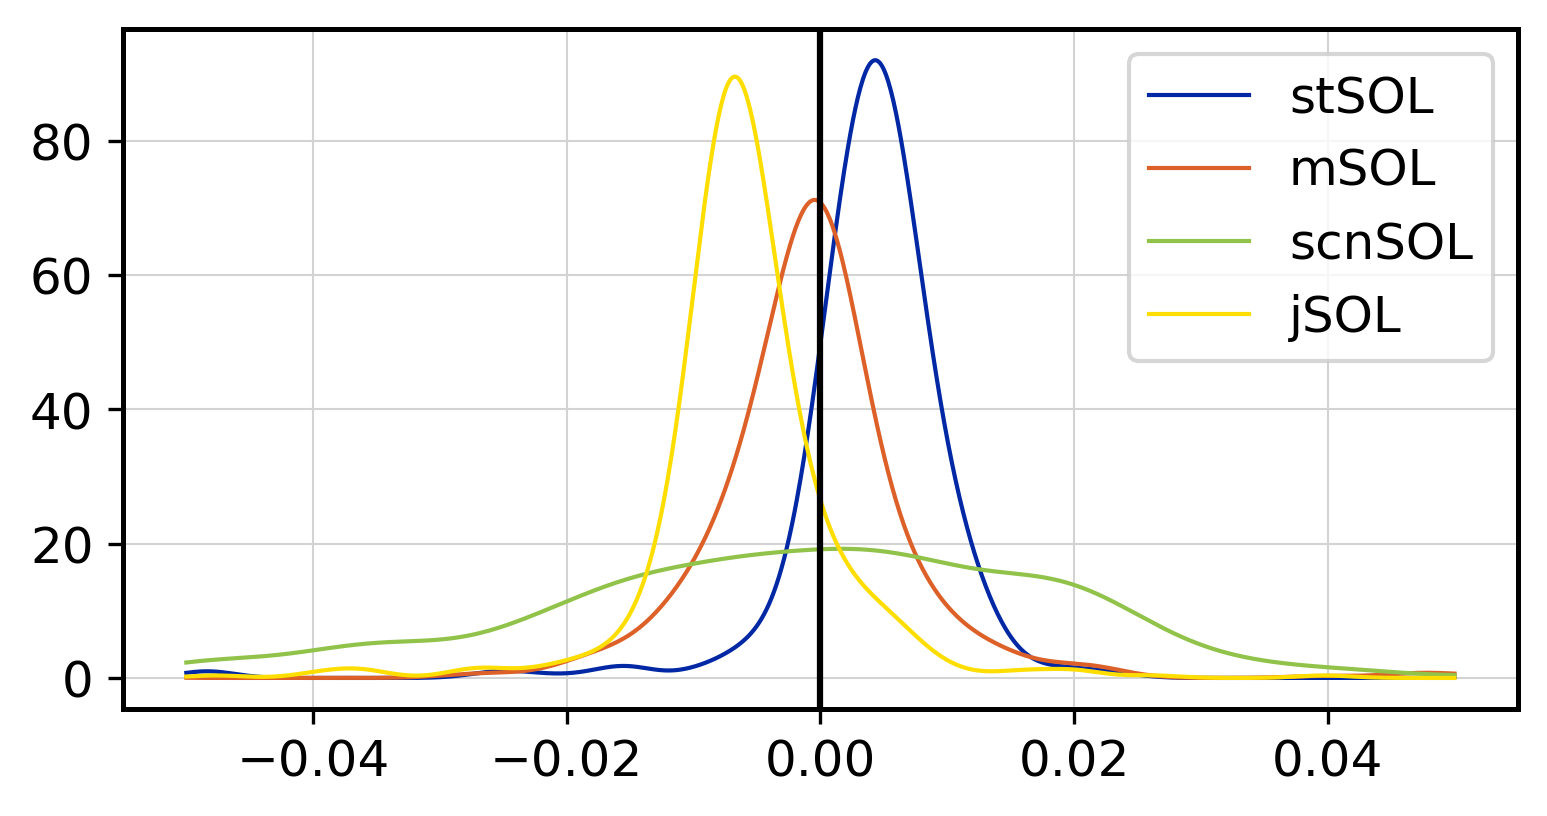

In [27]:
from scipy.stats import gaussian_kde


data_to_plot = ret_diff
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(6,3),dpi =300)

for col in data_to_plot:
    if col in ['daily', 'daily_accrued']:
        continue
    d = data_to_plot[data_to_plot[col].notnull()][col].values
    density = gaussian_kde(d)

    density.covariance_factor = lambda : 0.2
    density._compute_covariance()
    x = np.linspace(-0.05,0.05,1000)
    
    line = ax.plot(x,density(x),lw=1, label=col)
    #ax.fill_between(x,0,density(x), alpha = 0.1, color = line[0].get_color())

ax.axvline(0, color='k')
ax.set_axisbelow(True)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')

In [28]:
data_reg = pd.concat([excess_returns, interest.daily_SOL_change, interest.monthly_SOL_std, interest.daily_SOL_std_change, np.log(interest.market_cap), np.log(interest.total_volume)], axis=1, join="inner")
#for col in ['wstSOL', 'rSOL', 'cbSOL', 'sfrxSOL', 'ankrSOL']:
#    data_reg[col] = adjusted_results[col].pct_change(1)
data_reg

stSOL      mSOL    scnSOL      jSOL    daily  daily_accrued  \
2021-10-04       NaN       NaN       NaN       NaN  0.00016       1.000160   
2021-10-05  0.004334       NaN       NaN       NaN  0.00016       1.000319   
2021-10-06  0.001064       NaN       NaN       NaN  0.00016       1.000479   
2021-10-07 -0.027096       NaN       NaN       NaN  0.00016       1.000639   
2021-10-08  0.019818       NaN       NaN       NaN  0.00016       1.000799   
...              ...       ...       ...       ...      ...            ...   
2023-04-03 -0.003033 -0.001921 -0.012631 -0.000172  0.00016       1.091250   
2023-04-04 -0.004015 -0.001633  0.004503 -0.005028  0.00016       1.091424   
2023-04-05  0.003266  0.002940  0.001597  0.003515  0.00016       1.091598   
2023-04-06  0.000734 -0.001423  0.003606  0.000353  0.00016       1.091772   
2023-04-07 -0.002864  0.000594  0.005934  0.001340  0.00016       1.091947   

            daily_SOL_change  monthly_SOL_std  daily_SOL_std_change  \
2021-10-04          0.021553         0.079341             -0.041160   
2021-10-05         -0.028798         0.078989             -0.004424   
2021-10-06         -0.020900         0.079156              0.002106   
2021-10-07         -0.062510         0.074860             -0.054265   
2021-10-08          0.001072         0.074196             -0.008880   
...                      ...              ...                   ...   
2023-04-03         -0.024572         0.047131             -0.000480   
2023-04-04         -0.006260         0.046983             -0.003144   
2023-04-05          0.023703         0.047178              0.004145   
2023-04-06          0.002929         0.047047             -0.002772   
2023-04-07         -0.017795         0.047053              0.000129   

            market_cap  total_volume  
2021-10-04   24.666150     21.818671  
2021-10-05   24.636742     21.857442  
2021-10-06   24.615263     21.659373  
2021-10-07   24.551971     21.891419  
2021-10-08   24.555068     21.627277  
...                ...           ...  
2023-04-03   22.793873     19.340723  
2023-04-04   22.790150     20.087921  
2023-04-05   22.814330     19.669071  
2023-04-06   22.820029     19.706818  
2023-04-07   22.800323     19.421140  

[551 rows x 11 columns]

In [29]:
data_auto_reg = pd.concat([ret_diff, interest.daily_SOL_change, interest.monthly_SOL_std,interest.daily_SOL_std_change, np.log(interest.market_cap), np.log(interest.total_volume)], axis=1, join="inner")
for col in tokens:
    data_auto_reg['shift1_'+str(col)] = data_auto_reg[col].shift(1)
    data_auto_reg['shift2_'+str(col)] = data_auto_reg[col].shift(2)
    data_auto_reg['shift3_'+str(col)] = data_auto_reg[col].shift(3)
    data_auto_reg['shift4_'+str(col)] = data_auto_reg[col].shift(4)
    data_auto_reg['shift5_'+str(col)] = data_auto_reg[col].shift(5)
    data_auto_reg['shift6_'+str(col)] = data_auto_reg[col].shift(6)
data_auto_reg

stSOL      mSOL    scnSOL      jSOL    daily  daily_accrued  \
2021-10-04  0.000000       NaN       NaN       NaN  0.00016       1.000160   
2021-10-05  0.004334       NaN       NaN       NaN  0.00016       1.000319   
2021-10-06  0.005404       NaN       NaN       NaN  0.00016       1.000479   
2021-10-07 -0.021850       NaN       NaN       NaN  0.00016       1.000639   
2021-10-08 -0.002456       NaN       NaN       NaN  0.00016       1.000799   
...              ...       ...       ...       ...      ...            ...   
2023-04-03  0.010939  0.006035  0.001154  0.006839  0.00016       1.091250   
2023-04-04  0.006516  0.004244  0.006074  0.001319  0.00016       1.091424   
2023-04-05  0.010103  0.007466  0.007828  0.005161  0.00016       1.091598   
2023-04-06  0.010913  0.005904  0.011793  0.005549  0.00016       1.091772   
2023-04-07  0.007757  0.006556  0.018344  0.007020  0.00016       1.091947   

            daily_SOL_change  monthly_SOL_std  daily_SOL_std_change  \
2021-10-04          0.021553         0.079341             -0.041160   
2021-10-05         -0.028798         0.078989             -0.004424   
2021-10-06         -0.020900         0.079156              0.002106   
2021-10-07         -0.062510         0.074860             -0.054265   
2021-10-08          0.001072         0.074196             -0.008880   
...                      ...              ...                   ...   
2023-04-03         -0.024572         0.047131             -0.000480   
2023-04-04         -0.006260         0.046983             -0.003144   
2023-04-05          0.023703         0.047178              0.004145   
2023-04-06          0.002929         0.047047             -0.002772   
2023-04-07         -0.017795         0.047053              0.000129   

            market_cap  ...  shift3_scnSOL  shift4_scnSOL  shift5_scnSOL  \
2021-10-04   24.666150  ...            NaN            NaN            NaN   
2021-10-05   24.636742  ...            NaN            NaN            NaN   
2021-10-06   24.615263  ...            NaN            NaN            NaN   
2021-10-07   24.551971  ...            NaN            NaN            NaN   
2021-10-08   24.555068  ...            NaN            NaN            NaN   
...                ...  ...            ...            ...            ...   
2023-04-03   22.793873  ...      -0.005533       0.011064      -0.006030   
2023-04-04   22.790150  ...      -0.000364      -0.005533       0.011064   
2023-04-05   22.814330  ...       0.015124      -0.000364      -0.005533   
2023-04-06   22.820029  ...       0.001154       0.015124      -0.000364   
2023-04-07   22.800323  ...       0.006074       0.001154       0.015124   

            shift6_scnSOL  shift1_jSOL  shift2_jSOL  shift3_jSOL  shift4_jSOL  \
2021-10-04            NaN          NaN          NaN          NaN          NaN   
2021-10-05            NaN          NaN          NaN          NaN          NaN   
2021-10-06            NaN          NaN          NaN          NaN          NaN   
2021-10-07            NaN          NaN          NaN          NaN          NaN   
2021-10-08            NaN          NaN          NaN          NaN          NaN   
...                   ...          ...          ...          ...          ...   
2023-04-03       0.010136     0.007027     0.003131     0.002856    -0.004792   
2023-04-04      -0.006030     0.006839     0.007027     0.003131     0.002856   
2023-04-05       0.011064     0.001319     0.006839     0.007027     0.003131   
2023-04-06      -0.005533     0.005161     0.001319     0.006839     0.007027   
2023-04-07      -0.000364     0.005549     0.005161     0.001319     0.006839   

            shift5_jSOL  shift6_jSOL  
2021-10-04          NaN          NaN  
2021-10-05          NaN          NaN  
2021-10-06          NaN          NaN  
2021-10-07          NaN          NaN  
2021-10-08          NaN          NaN  
...                 ...          ...  
2023-04-03    -0.000048    -0.000005  
2023-04-04    -0.004792    

In [30]:
#exclude daily as variable since constant 
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from statsmodels.stats.outliers_influence import variance_inflation_factor
for col in tokens:
    df_reg = data_reg[['daily_SOL_change', 'monthly_SOL_std','daily_SOL_std_change', 'market_cap','total_volume' ,str(col) ]].dropna()
    X = df_reg[['daily_SOL_change', 'monthly_SOL_std','daily_SOL_std_change', 'market_cap', 'total_volume']]
    y = df_reg[str(col)]
    #demean data
    X = X - X.mean()
    X = sm.add_constant(X)
                            
    #Calculate and print variance inflation factor (VIF)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                    for i in range(len(X.columns))]
    print(vif_data)
    model_ols = sm.OLS(y,X)
    ols_res = model_ols.fit(cov_type='HAC', cov_kwds={'maxlags':10})
    print(ols_res.summary())

                feature       VIF
0                 const  1.000000
1      daily_SOL_change  1.005160
2       monthly_SOL_std  1.107783
3  daily_SOL_std_change  1.185092
4            market_cap  2.579830
5          total_volume  2.589063
                            OLS Regression Results                            
Dep. Variable:                  stSOL   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.526
Date:                Mon, 15 May 2023   Prob (F-statistic):              0.180
Time:                        17:42:46   Log-Likelihood:                 1702.0
No. Observations:                 550   AIC:                            -3392.
Df Residuals:                     544   BIC:                            -3366.
Df Model:                           5                                         
Covariance Type:                  HAC              

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [31]:
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from statsmodels.stats.outliers_influence import variance_inflation_factor
for col in tokens:
    df_auto_reg = data_auto_reg[['daily_SOL_change', 'monthly_SOL_std', 'market_cap', 'total_volume' ,str(col),'shift1_'+str(col),'daily_SOL_std_change',
                                 'shift2_'+str(col),'shift3_'+str(col),'shift4_'+str(col),'shift5_'+str(col),'shift6_'+str(col) ]].dropna()
    X = df_auto_reg[['shift1_'+str(col),'shift2_'+str(col),'shift3_'+str(col),'shift4_'+str(col),'shift5_'+str(col),'shift6_'+str(col),'daily_SOL_change', 'monthly_SOL_std','daily_SOL_std_change', 'market_cap', 'total_volume']]
    #demean data
    X = X - X.mean()
    y = df_auto_reg[str(col)]
    X = sm.add_constant(X)
                        
    #Calculate and print variance inflation factor (VIF)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                    for i in range(len(X.columns))]
    print(vif_data)
    model_ols = sm.OLS(y,X)
    ols_res = model_ols.fit(cov_type='HAC', cov_kwds={'maxlags':10}) 
    print(ols_res.summary())

                 feature       VIF
0                  const  1.000000
1           shift1_stSOL  1.450491
2           shift2_stSOL  1.487847
3           shift3_stSOL  1.485534
4           shift4_stSOL  1.476080
5           shift5_stSOL  1.471150
6           shift6_stSOL  1.292980
7       daily_SOL_change  1.027900
8        monthly_SOL_std  1.189062
9   daily_SOL_std_change  1.319545
10            market_cap  2.745187
11          total_volume  2.767733
                            OLS Regression Results                            
Dep. Variable:                  stSOL   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     10.35
Date:                Mon, 15 May 2023   Prob (F-statistic):           2.83e-17
Time:                        17:42:46   Log-Likelihood:                 1778.5
No. Observations:                 545   AIC:                           

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
